In [1]:
import os
import json
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Veri yolunu belirtin
data_path = "/content/drive/MyDrive/Classroom/BigDataDersi/my_dataset"

# Tüm JSON dosyalarını toplamak için boş bir liste oluşturun
all_dataframes = []

# data_path altındaki tüm dosya ve klasörlerde dolaşın
for root, dirs, files in os.walk(data_path):
  for file in files:
    # Sadece .json uzantılı dosyaları işleyin
    if file.endswith(".json"):
      file_path = os.path.join(root, file)
      try:
        # JSON dosyasını pandas DataFrame olarak okuyun
        df = pd.read_json(file_path)
        # DataFrame'e dosya adını ve klasör yolunu içeren sütunlar ekleyebilirsiniz (isteğe bağlı)
        df['file_name'] = file
        df['directory'] = root
        # DataFrame'i listeye ekleyin
        all_dataframes.append(df)
      except Exception as e:
        print(f"Dosya okunurken hata oluştu {file_path}: {e}")

# Tüm DataFrame'leri tek bir DataFrame'de birleştirin
if all_dataframes:
  combined_df = pd.concat(all_dataframes, ignore_index=True)
  print("Veri başarıyla okundu ve birleştirildi.")
  # Birleştirilmiş DataFrame'in ilk birkaç satırını görüntüleyin
  print(combined_df.head())
else:
  print("Okunacak JSON dosyası bulunamadı.")

Veri başarıyla okundu ve birleştirildi.
  ip_proto  port_dst  port_src  \
0      tcp       443     52538   
1      tcp       443     52538   
2      tcp       443     52538   
3      tcp       443     52538   
4      tcp       443     52538   

                                           x_packets  file_name  \
0  [{'bytes': '169', 'ip_header_len': '20', 'pack...  meet.json   
1  [{'bytes': '52', 'ip_header_len': '20', 'packe...  meet.json   
2  [{'bytes': '169', 'ip_header_len': '20', 'pack...  mail.json   
3  [{'bytes': '169', 'ip_header_len': '20', 'pack...  mail.json   
4  [{'bytes': '169', 'ip_header_len': '20', 'pack...  mail.json   

                                           directory  
0  /content/drive/MyDrive/Classroom/BigDataDersi/...  
1  /content/drive/MyDrive/Classroom/BigDataDersi/...  
2  /content/drive/MyDrive/Classroom/BigDataDersi/...  
3  /content/drive/MyDrive/Classroom/BigDataDersi/...  
4  /content/drive/MyDrive/Classroom/BigDataDersi/...  


In [ ]:
!pip install tensorflow

In [ ]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# === Ayarlar ===
base_path = '/content/drive/MyDrive/Classroom/BigDataDersi/my_dataset'
vpn_folders = ['SSTP', 'OpenVPN', 'PPTP', 'L2TP', 'WireGuard', 'L2TP IPsec']
file_names = ['meet.json', 'mail.json', 'ssh.json', 'streaming.json','non_streaming.json']

data = []

# VPN verileri
for folder in vpn_folders:
    for file_name in file_names:
        path = os.path.join(base_path, 'VPN', folder, file_name)
        if os.path.isfile(path):
            with open(path) as f:
                try:
                    sessions = json.load(f)
                    for session in sessions:
                        proto = session.get("ip_proto", "").lower()
                        for packet in session.get("x_packets", []):
                            try:
                                data.append({
                                    "bytes": int(packet.get("bytes", 0)),
                                    "ip_proto": 1 if proto == "tcp" else 0,
                                    "port_src": session.get("port_src", -1),
                                    "port_dst": session.get("port_dst", -1),
                                    "tcp_flags": int(packet.get("tcp_flags", "000000"), 2) if proto == "tcp" else 0,
                                    "tcp_header_len": int(packet.get("tcp_header_len", 0)) if proto == "tcp" else 0,
                                    "vpn": 1
                                })
                            except:
                                continue
                except:
                    continue

# Non-VPN verileri
non_vpn_path = os.path.join(base_path, 'Non VPN')
for file_name in file_names:
    path = os.path.join(non_vpn_path, file_name)
    if os.path.isfile(path):
        with open(path) as f:
            try:
                sessions = json.load(f)
                for session in sessions:
                    proto = session.get("ip_proto", "").lower()
                    for packet in session.get("x_packets", []):
                        try:
                            data.append({
                                "bytes": int(packet.get("bytes", 0)),
                                "ip_proto": 1 if proto == "tcp" else 0,
                                "port_src": session.get("port_src", -1),
                                "port_dst": session.get("port_dst", -1),
                                "tcp_flags": int(packet.get("tcp_flags", "000000"), 2) if proto == "tcp" else 0,
                                "tcp_header_len": int(packet.get("tcp_header_len", 0)) if proto == "tcp" else 0,
                                "vpn": 0
                            })
                        except:
                            continue
            except:
                continue

# DataFrame oluştur
df = pd.DataFrame(data)
df = df[df['bytes'] >= 0]

# Özellik ve hedef ayır
X = df.drop(columns=['vpn'])
y = df['vpn']

# Standardize et (zorunlu değil ama faydalı olabilir)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Eğitim/Test bölmesi
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🎯 RandomForest Modeli
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Test
y_pred = model.predict(X_test)

# Değerlendirme
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 🔐 Modeli kaydet (.pkl)
joblib.dump(model, '/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_detection_rf_model.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_detection_scaler.pkl')


✅ Accuracy: 0.9384574406977746

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91   2234120
           1       0.99      0.92      0.95   5008104

    accuracy                           0.94   7242224
   macro avg       0.92      0.95      0.93   7242224
weighted avg       0.95      0.94      0.94   7242224


🧩 Confusion Matrix:
 [[2208018   26102]
 [ 419603 4588501]]


['/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_detection_scaler.pkl']

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


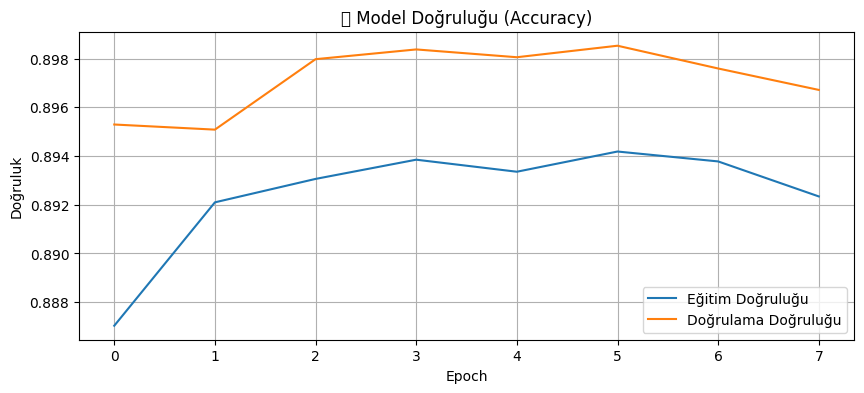

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


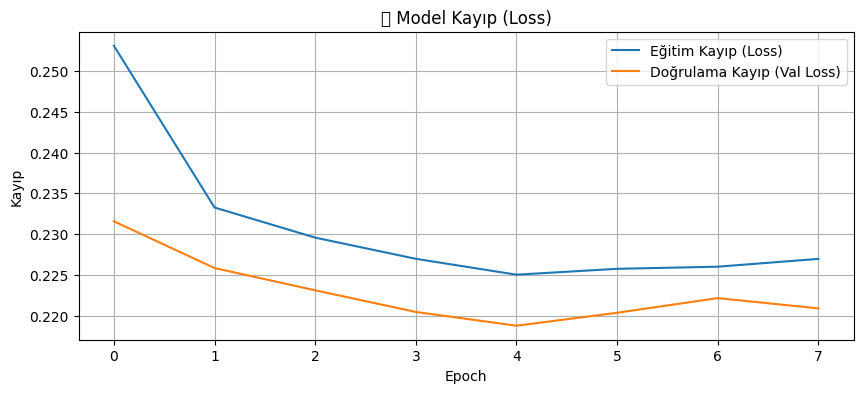

In [ ]:
import matplotlib.pyplot as plt

# Accuracy grafiği
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('📈 Model Doğruluğu (Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)
plt.show()

# Loss grafiği
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Eğitim Kayıp (Loss)')
plt.plot(history.history['val_loss'], label='Doğrulama Kayıp (Val Loss)')
plt.title('📉 Model Kayıp (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


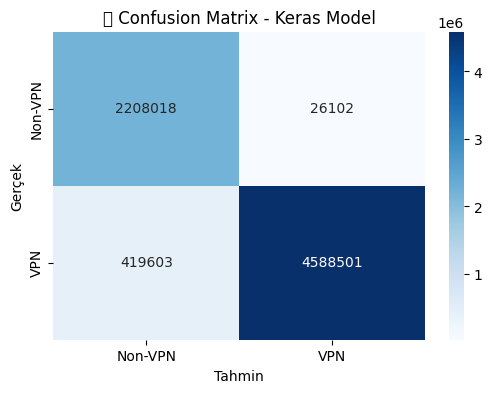

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Tahmin yap
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Görselleştir
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-VPN', 'VPN'], yticklabels=['Non-VPN', 'VPN'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('🔐 Confusion Matrix - Keras Model')
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


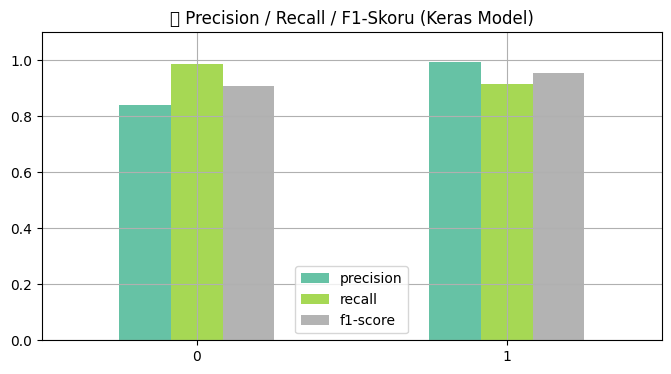

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Raporu al
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])

# Barplot çiz
df_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(8, 4), colormap='Set2')
plt.title("📊 Precision / Recall / F1-Skoru (Keras Model)")
plt.ylim(0, 1.1)
plt.grid(True)
plt.xticks(rotation=0)
plt.show()


In [ ]:
import os
import json
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

base_path = '/content/drive/MyDrive/Classroom/BigDataDersi/my_dataset'
vpn_folders = ['SSTP', 'OpenVPN', 'PPTP', 'L2TP', 'WireGuard', 'L2TP IPsec']
file_names = ['meet.json', 'mail.json', 'ssh.json', 'streaming.json','non_streaming.json']

data = []

for folder in vpn_folders:
    for file_name in file_names:
        path = os.path.join(base_path, 'VPN', folder, file_name)
        if os.path.isfile(path):
            with open(path) as f:
                try:
                    sessions = json.load(f)
                    for session in sessions:
                        proto = session.get("ip_proto", "").lower()
                        for packet in session.get("x_packets", []):
                            try:
                                data.append({
                                    "bytes": int(packet.get("bytes", 0)),
                                    "ip_proto": 1 if proto == "tcp" else 0,
                                    "port_src": session.get("port_src", -1),
                                    "port_dst": session.get("port_dst", -1),
                                    "tcp_flags": int(packet.get("tcp_flags", "000000"), 2) if proto == "tcp" else 0,
                                    "tcp_header_len": int(packet.get("tcp_header_len", 0)) if proto == "tcp" else 0,
                                    "vpn": 1
                                })
                            except:
                                continue
                except:
                    continue

# Non-VPN verileri
non_vpn_path = os.path.join(base_path, 'Non VPN')
for file_name in file_names:
    path = os.path.join(non_vpn_path, file_name)
    if os.path.isfile(path):
        with open(path) as f:
            try:
                sessions = json.load(f)
                for session in sessions:
                    proto = session.get("ip_proto", "").lower()
                    for packet in session.get("x_packets", []):
                        try:
                            data.append({
                                "bytes": int(packet.get("bytes", 0)),
                                "ip_proto": 1 if proto == "tcp" else 0,
                                "port_src": session.get("port_src", -1),
                                "port_dst": session.get("port_dst", -1),
                                "tcp_flags": int(packet.get("tcp_flags", "000000"), 2) if proto == "tcp" else 0,
                                "tcp_header_len": int(packet.get("tcp_header_len", 0)) if proto == "tcp" else 0,
                                "vpn": 0
                            })
                        except:
                            continue
            except:
                continue

df = pd.DataFrame(data)
df = df[df['bytes'] >= 0]
print("✅ 'df' DataFrame'i başarıyla oluşturuldu!")

model_path = '/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_detection_rf_model.pkl'
scaler_path = '/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_detection_scaler.pkl'

try:
    print("✅ Model ve Scaler başarıyla yüklendi (ancak bu görselleştirme için doğrudan kullanılmadılar).")
except FileNotFoundError:
    print(f"Hata: Model veya Scaler dosyaları bulunamadı. Lütfen yolların doğru olduğundan emin olun:")
    print(f"- Model yolu: {model_path}")
    print(f"- Scaler yolu: {scaler_path}")
except Exception as e:
    print(f"Yükleme sırasında bir hata oluştu: {e}")

vpn_counts = df['vpn'].value_counts()
labels = ['Non-VPN', 'VPN']
colors = ['#ff9999','#66b3ff']
explode = (0.05, 0.05)
plt.figure(figsize=(7, 7))
plt.pie(vpn_counts, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('VPN ve Non-VPN Paket Dağılımı')
plt.axis('equal')
plt.show()



NameError: name 'df' is not defined

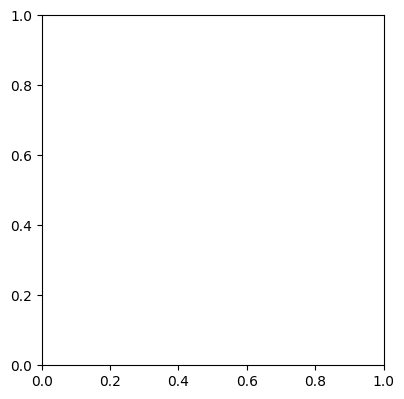

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sadece seçili sayısal özellikler için histogramlar
numerical_features = ['bytes', 'port_src', 'port_dst', 'tcp_flags', 'tcp_header_len']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[df['vpn'] == 0][feature], color='blue', label='Non-VPN', kde=True, stat="density", linewidth=0)
    sns.histplot(df[df['vpn'] == 1][feature], color='red', label='VPN', kde=True, stat="density", linewidth=0)
    plt.title(f'{feature} Dağılımı (VPN vs Non-VPN)')
    plt.xlabel(feature)
    plt.ylabel('Yoğunluk')
    plt.legend()
plt.tight_layout()
plt.show()

# ip_proto için (0 ve 1 olduğu için) sütun grafiği daha uygun
plt.figure(figsize=(6, 5))
# Palet anahtarlarını tamsayı (0 ve 1) olarak güncelledik
sns.countplot(data=df, x='ip_proto', hue='vpn', palette={0: 'blue', 1: 'red'}, legend=False)
plt.title('IP Protokolü Dağılımı (0: UDP, 1: TCP)')
plt.xlabel('IP Protokolü')
plt.ylabel('Sayı')
plt.xticks(ticks=[0, 1], labels=['UDP', 'TCP'])
# Manuel legend ekleme
handles = [plt.Rectangle((0,0),1,1, color=sns.color_palette()[0]),
           plt.Rectangle((0,0),1,1, color=sns.color_palette()[3])]
plt.legend(handles, ['Non-VPN', 'VPN'], title="Tür")
plt.show()

AŞAĞIDA HANGİ VPN OLDUĞU YAZIYOR

In [ ]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# === Ayarlar ===
base_path = '/content/drive/MyDrive/Classroom/BigDataDersi/my_dataset/VPN'
vpn_folders = ['SSTP', 'OpenVPN', 'PPTP', 'L2TP', 'WireGuard', 'L2TP IPsec']
file_names = ['meet.json', 'mail.json', 'ssh.json', 'streaming.json','non_streaming.json']

data = []

# VPN klasörlerinden veri oku
for folder in vpn_folders:
    for file_name in file_names:
        path = os.path.join(base_path, folder, file_name)
        if not os.path.isfile(path):
            continue
        with open(path) as f:
            try:
                sessions = json.load(f)
                for session in sessions:
                    proto = session.get("ip_proto", "").lower()
                    for packet in session.get("x_packets", []):
                        try:
                            data.append({
                                "bytes": int(packet.get("bytes", 0)),
                                "ip_proto": 1 if proto == "tcp" else 0,
                                "port_src": session.get("port_src", -1),
                                "port_dst": session.get("port_dst", -1),
                                "tcp_flags": int(packet.get("tcp_flags", "000000"), 2) if proto == "tcp" else 0,
                                "tcp_header_len": int(packet.get("tcp_header_len", 0)) if proto == "tcp" else 0,
                                "vpn_type": folder
                            })
                        except:
                            continue
            except:
                continue

# DataFrame oluştur
df = pd.DataFrame(data)
df = df[df['bytes'] >= 0]

# VPN türünü label encode et
le = LabelEncoder()
df['vpn_type_encoded'] = le.fit_transform(df['vpn_type'])

# Özellikler ve hedef
X = df[['bytes', 'ip_proto', 'port_src', 'port_dst', 'tcp_flags', 'tcp_header_len']]
y = df['vpn_type_encoded']

# Standardize et
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test böl
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🎯 Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Test
y_pred = model.predict(X_test)

# Değerlendirme
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Model ve encoder'ları kaydet
joblib.dump(model, '/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_type_model.pkl')
joblib.dump(le, '/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_type_label_encoder.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_type_scaler.pkl')


✅ Accuracy: 0.9998209290965064

📊 Classification Report:
               precision    recall  f1-score   support

        L2TP       1.00      1.00      1.00    639884
  L2TP IPsec       1.00      1.00      1.00    983257
     OpenVPN       1.00      1.00      1.00    572862
        PPTP       1.00      1.00      1.00    969898
        SSTP       1.00      1.00      1.00    714876
   WireGuard       1.00      1.00      1.00   1128412

    accuracy                           1.00   5009189
   macro avg       1.00      1.00      1.00   5009189
weighted avg       1.00      1.00      1.00   5009189


🧩 Confusion Matrix:
 [[ 639815      69       0       0       0       0]
 [      0  983255       0       0       0       2]
 [      0       0  572862       0       0       0]
 [      0       0       0  969898       0       0]
 [      0       0       0       0  714876       0]
 [      0     826       0       0       0 1127586]]


['/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_type_scaler.pkl']

<ipython-input-14-34bcb4cff542>:25: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


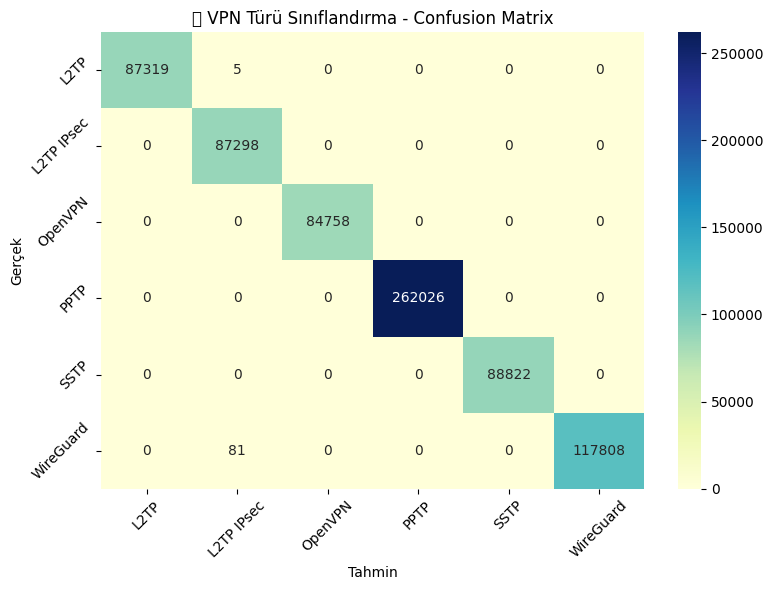

In [ ]:
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Kaydedilen model ve label encoder'ı yükle
model = joblib.load('/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_type_model.pkl')
le = joblib.load('/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_type_label_encoder.pkl')

# Test tahminleri (önceden zaten vardıysa tekrar gerek yok)
y_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = le.classes_

# Görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("🔐 VPN Türü Sınıflandırma - Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


 1. VPN Türlerine Göre Trafik Miktarı (Pasta Grafiği)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


<ipython-input-6-a093ba4fcd58>:7: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


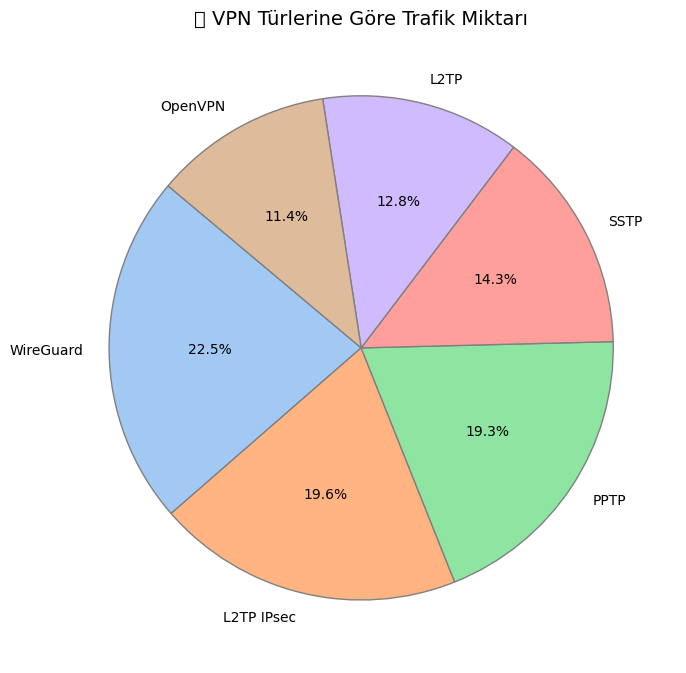

In [ ]:
vpn_counts = df['vpn_type'].value_counts()

plt.figure(figsize=(7, 7))
colors = sns.color_palette("pastel")
plt.pie(vpn_counts, labels=vpn_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'gray'})
plt.title("🎯 VPN Türlerine Göre Trafik Miktarı", fontsize=14)
plt.tight_layout()
plt.show()


3. VPN Türüne Göre TCP vs UDP Kullanımı (Stacked Bar)

<ipython-input-8-9dac5489711f>:9: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


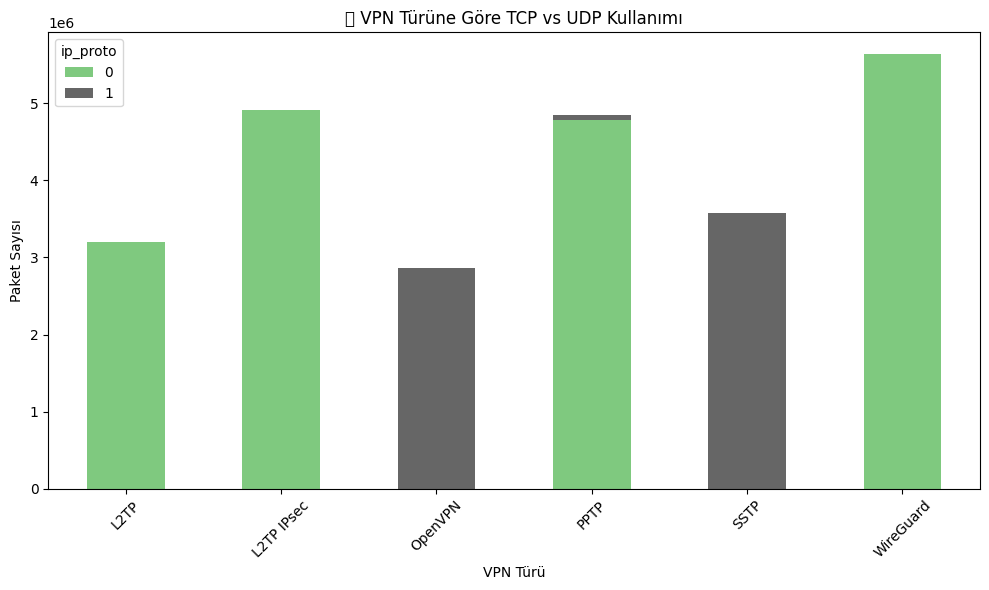

In [ ]:
proto_dist = df.groupby(['vpn_type', 'ip_proto']).size().unstack().fillna(0)
proto_dist = proto_dist.rename(columns={'tcp': 'TCP', 'udp': 'UDP'})

proto_dist.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Accent')
plt.title("🌐 VPN Türüne Göre TCP vs UDP Kullanımı")
plt.xlabel("VPN Türü")
plt.ylabel("Paket Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


5. VPN Türüne Göre Toplam Veri Miktarı (Donut Grafiği)

<ipython-input-10-c6426fc93d56>:7: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


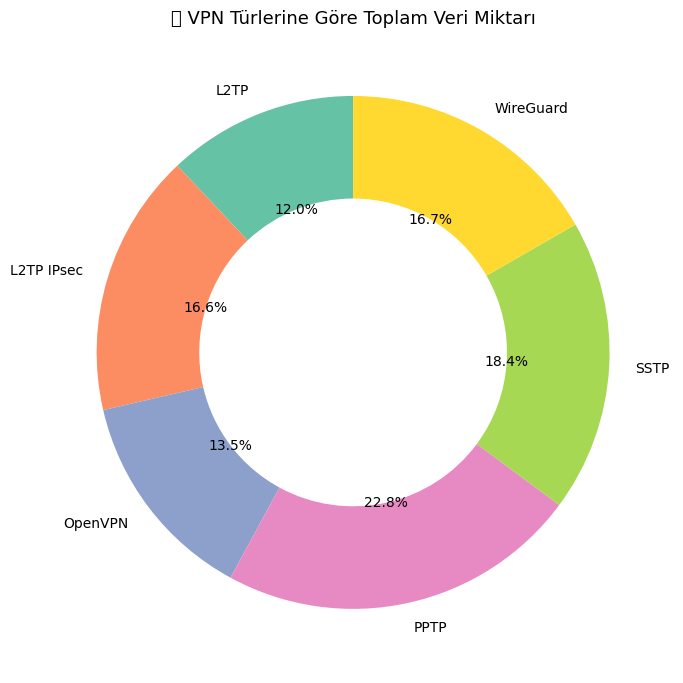

In [ ]:
total_bytes_vpn = df.groupby("vpn_type")["bytes"].sum()

plt.figure(figsize=(7, 7))
colors = sns.color_palette("Set2")
plt.pie(total_bytes_vpn, labels=total_bytes_vpn.index, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(width=0.4))
plt.title("📡 VPN Türlerine Göre Toplam Veri Miktarı", fontsize=13)
plt.tight_layout()
plt.show()


6. TCP Flags Dağılımı (Bar + Renk Geçişli)

<ipython-input-12-8f15b10ea0c9>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=flag_counts.index, y=flag_counts.values, palette=sns.color_palette("flare", len(flag_counts)))
<ipython-input-12-8f15b10ea0c9>:15: UserWarning: Glyph 128681 (\N{TRIANGULAR FLAG ON POST}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128681 (\N{TRIANGULAR FLAG ON POST}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


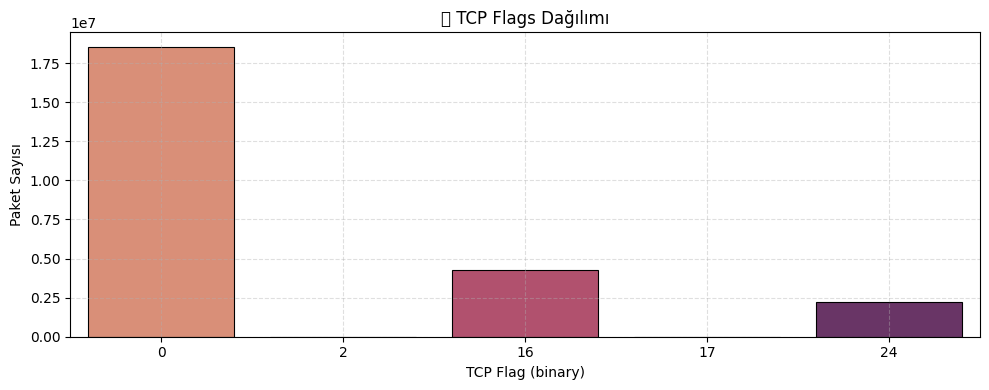

In [ ]:
tcp_df = df[df['tcp_flags'].notna()]
flag_counts = tcp_df['tcp_flags'].value_counts()

plt.figure(figsize=(10, 4))
bars = sns.barplot(x=flag_counts.index, y=flag_counts.values, palette=sns.color_palette("flare", len(flag_counts)))
plt.title("🚩 TCP Flags Dağılımı")
plt.xlabel("TCP Flag (binary)")
plt.ylabel("Paket Sayısı")
plt.grid(True, linestyle='--', alpha=0.4)

for bar in bars.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(0.8)

plt.tight_layout()
plt.show()


7. ÖNEM DERECESİ VPN TÜRÜ

<ipython-input-13-7a0999cfbe83>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='viridis')
<ipython-input-13-7a0999cfbe83>:10: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


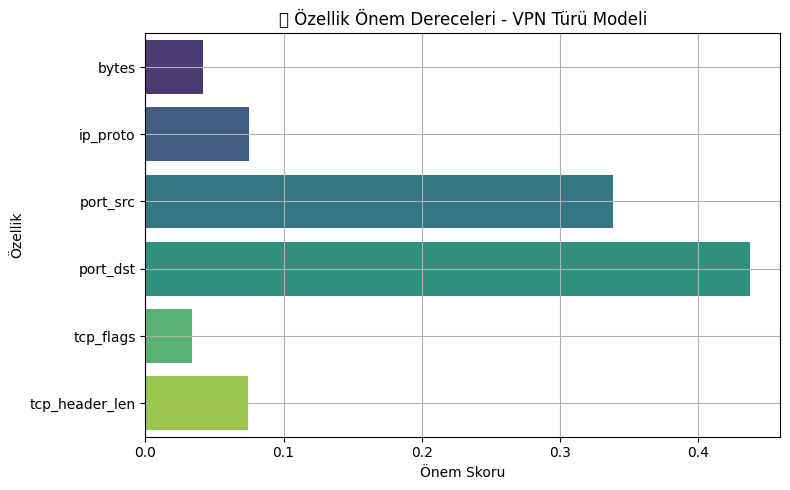

In [ ]:
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, palette='viridis')
plt.title("🧠 Özellik Önem Dereceleri - VPN Türü Modeli")
plt.xlabel("Önem Skoru")
plt.ylabel("Özellik")
plt.grid(True)
plt.tight_layout()
plt.show()


Ağ Trafiği Özelliklerinin VPN Türlerine Göre Dağılımı

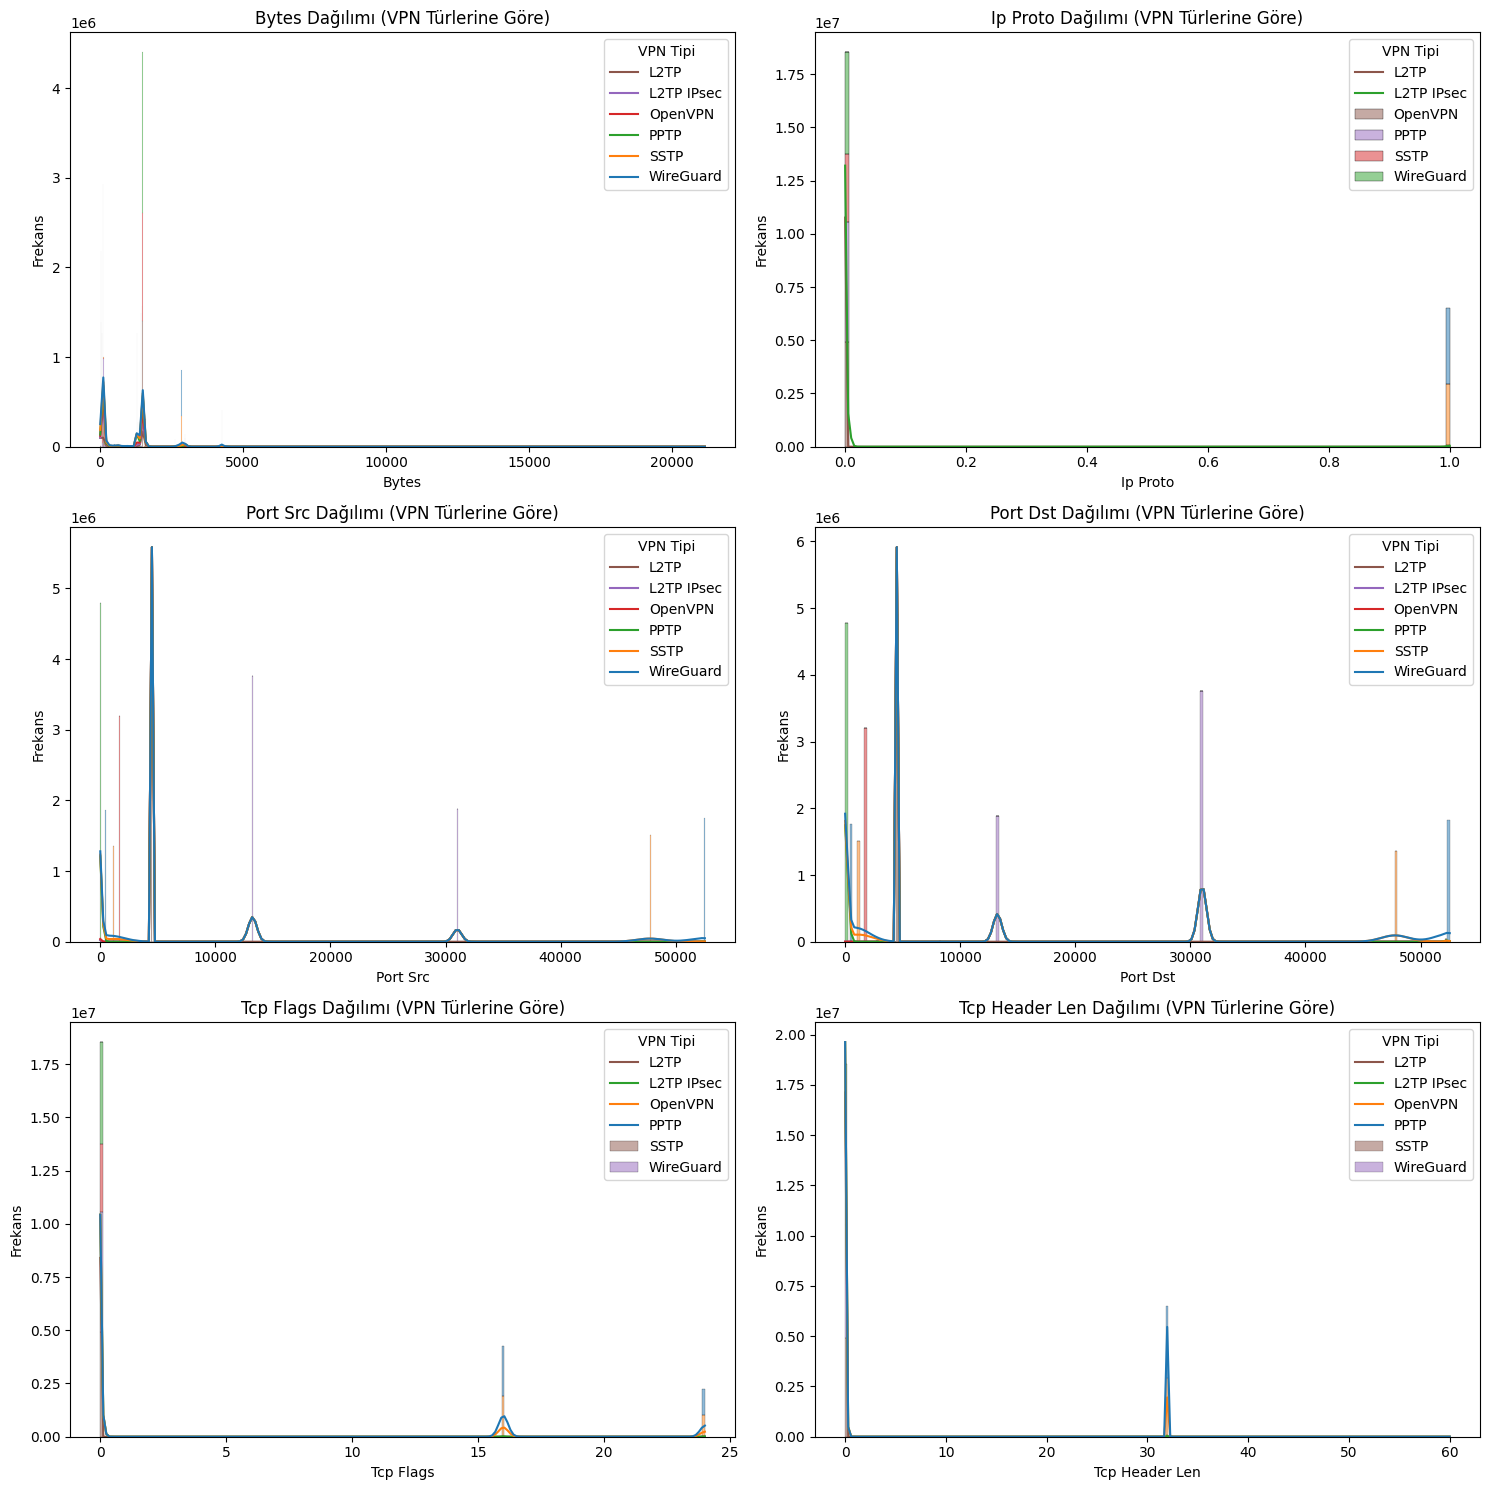

In [ ]:
features = ['bytes', 'ip_proto', 'port_src', 'port_dst', 'tcp_flags', 'tcp_header_len']
n_features = len(features)
n_cols = 2 # Her satırda 2 sütun grafik
n_rows = (n_features + n_cols - 1) // n_cols # Gerekli satır sayısı

plt.figure(figsize=(15, 5 * n_rows))

for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data=df, x=feature, hue='vpn_type', kde=True, palette='tab10', multiple="stack")
    plt.title(f'{feature.replace("_", " ").title()} Dağılımı (VPN Türlerine Göre)')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Frekans')
    plt.legend(title='VPN Tipi', labels=le.classes_) # Legend'ı güncel classes ile göster
plt.tight_layout()
plt.show()

Feature Importances (Özellik Önem Dereceleri)

<ipython-input-16-0276e926027e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='magma')
<ipython-input-16-0276e926027e>:13: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


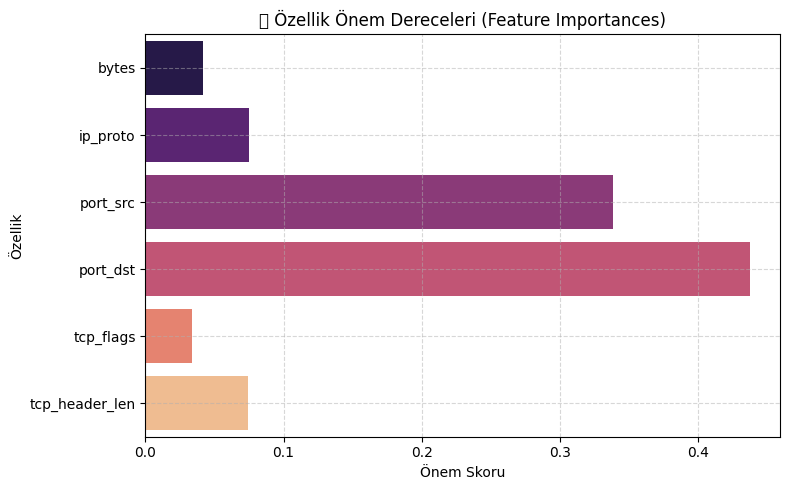

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, palette='magma')
plt.title("🧠 Özellik Önem Dereceleri (Feature Importances)")
plt.xlabel("Önem Skoru")
plt.ylabel("Özellik")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Learning Curve (Öğrenme Eğrisi)

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Eğitim Skoru', marker='o', color='blue')
plt.plot(train_sizes, test_mean, label='Doğrulama Skoru', marker='s', color='green')
plt.fill_between(train_sizes, train_mean - np.std(train_scores, axis=1), train_mean + np.std(train_scores, axis=1), alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - np.std(test_scores, axis=1), test_mean + np.std(test_scores, axis=1), alpha=0.2, color='green')
plt.title("📈 Learning Curve - Modelin Öğrenme Kapasitesi")
plt.xlabel("Eğitim Verisi Miktarı")
plt.ylabel("Doğruluk")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

PCA ile 2D Veri Görselleştirmesi

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set2', alpha=0.7)
plt.title("🌐 PCA ile VPN Türlerinin 2D Görselleştirmesi")
plt.xlabel("1. Bileşen")
plt.ylabel("2. Bileşen")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-18-fe3582c12aa8>:12: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-fe3582c12aa8>:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


KeyboardInterrupt: 

Gerçek vs Tahmin (Etkileşimli Dağılım Grafiği)

<ipython-input-19-0c5fb65b59cc>:10: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-19-0c5fb65b59cc>:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


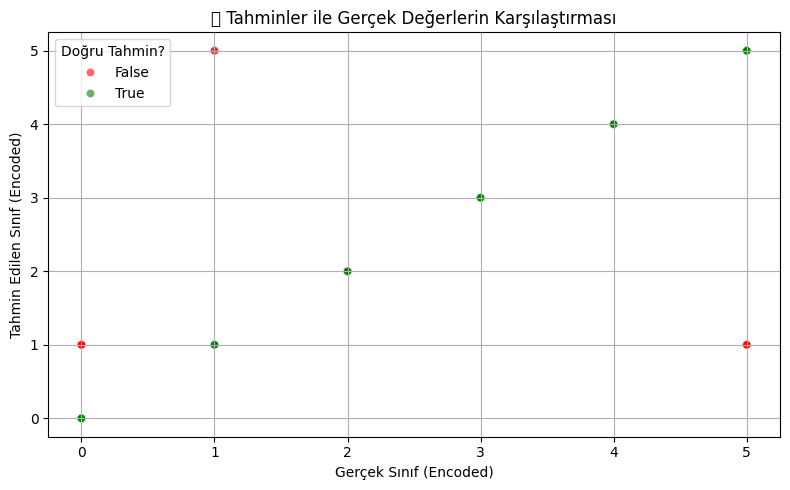

In [ ]:
import numpy as np

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, hue=(y_test == y_pred), palette={True: 'green', False: 'red'}, alpha=0.6)
plt.title("🎯 Tahminler ile Gerçek Değerlerin Karşılaştırması")
plt.xlabel("Gerçek Sınıf (Encoded)")
plt.ylabel("Tahmin Edilen Sınıf (Encoded)")
plt.grid(True)
plt.legend(title="Doğru Tahmin?")
plt.tight_layout()
plt.show()


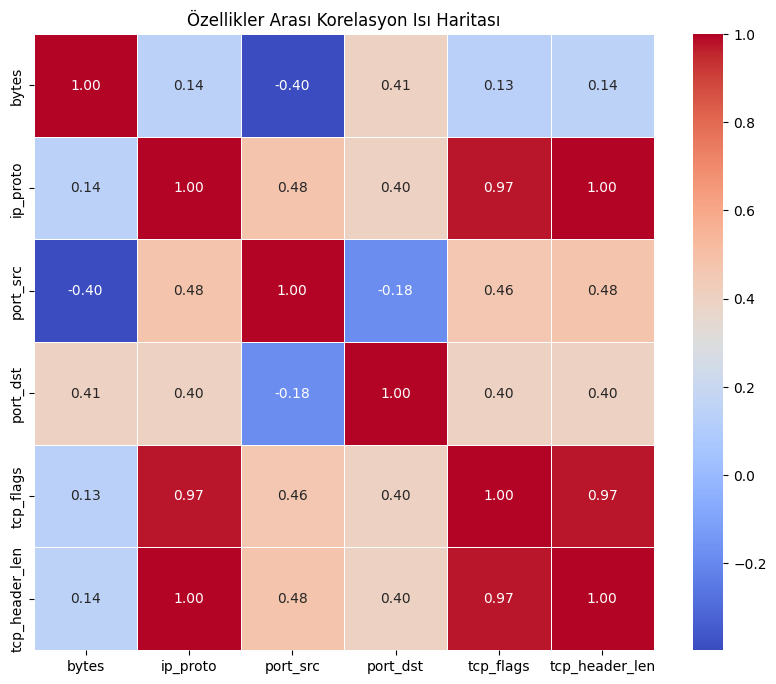

In [ ]:
plt.figure(figsize=(10, 8))
# Sadece sayısal özelliklerin korelasyonunu hesapla
correlation_matrix = df[features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Özellikler Arası Korelasyon Isı Haritası')
plt.show()

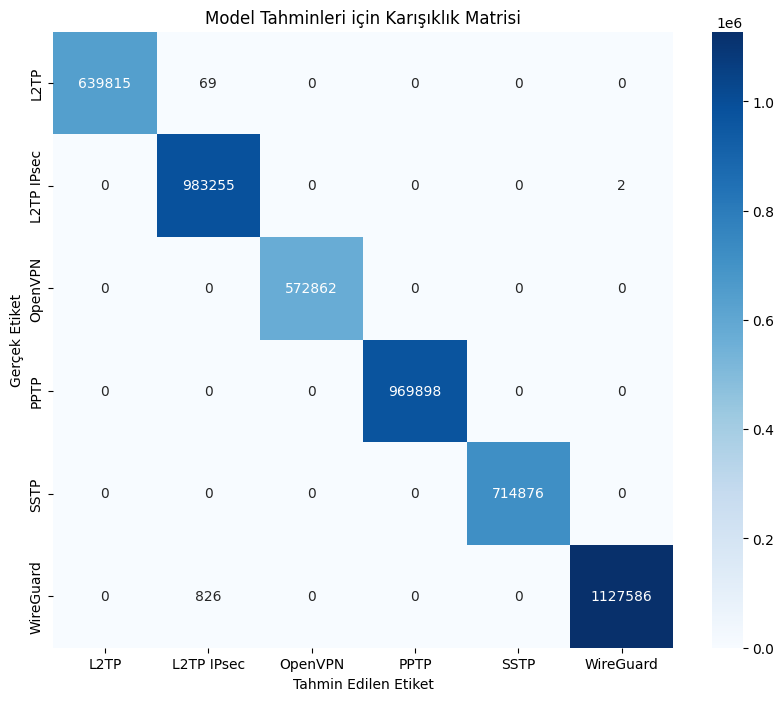

In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Model Tahminleri için Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.show()

<ipython-input-11-8659e7ed187e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='vpn_type', y=feature, palette='viridis')
<ipython-input-11-8659e7ed187e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='vpn_type', y=feature, palette='viridis')
<ipython-input-11-8659e7ed187e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='vpn_type', y=feature, palette='viridis')
<ipython-input-11-8659e7ed187e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assig

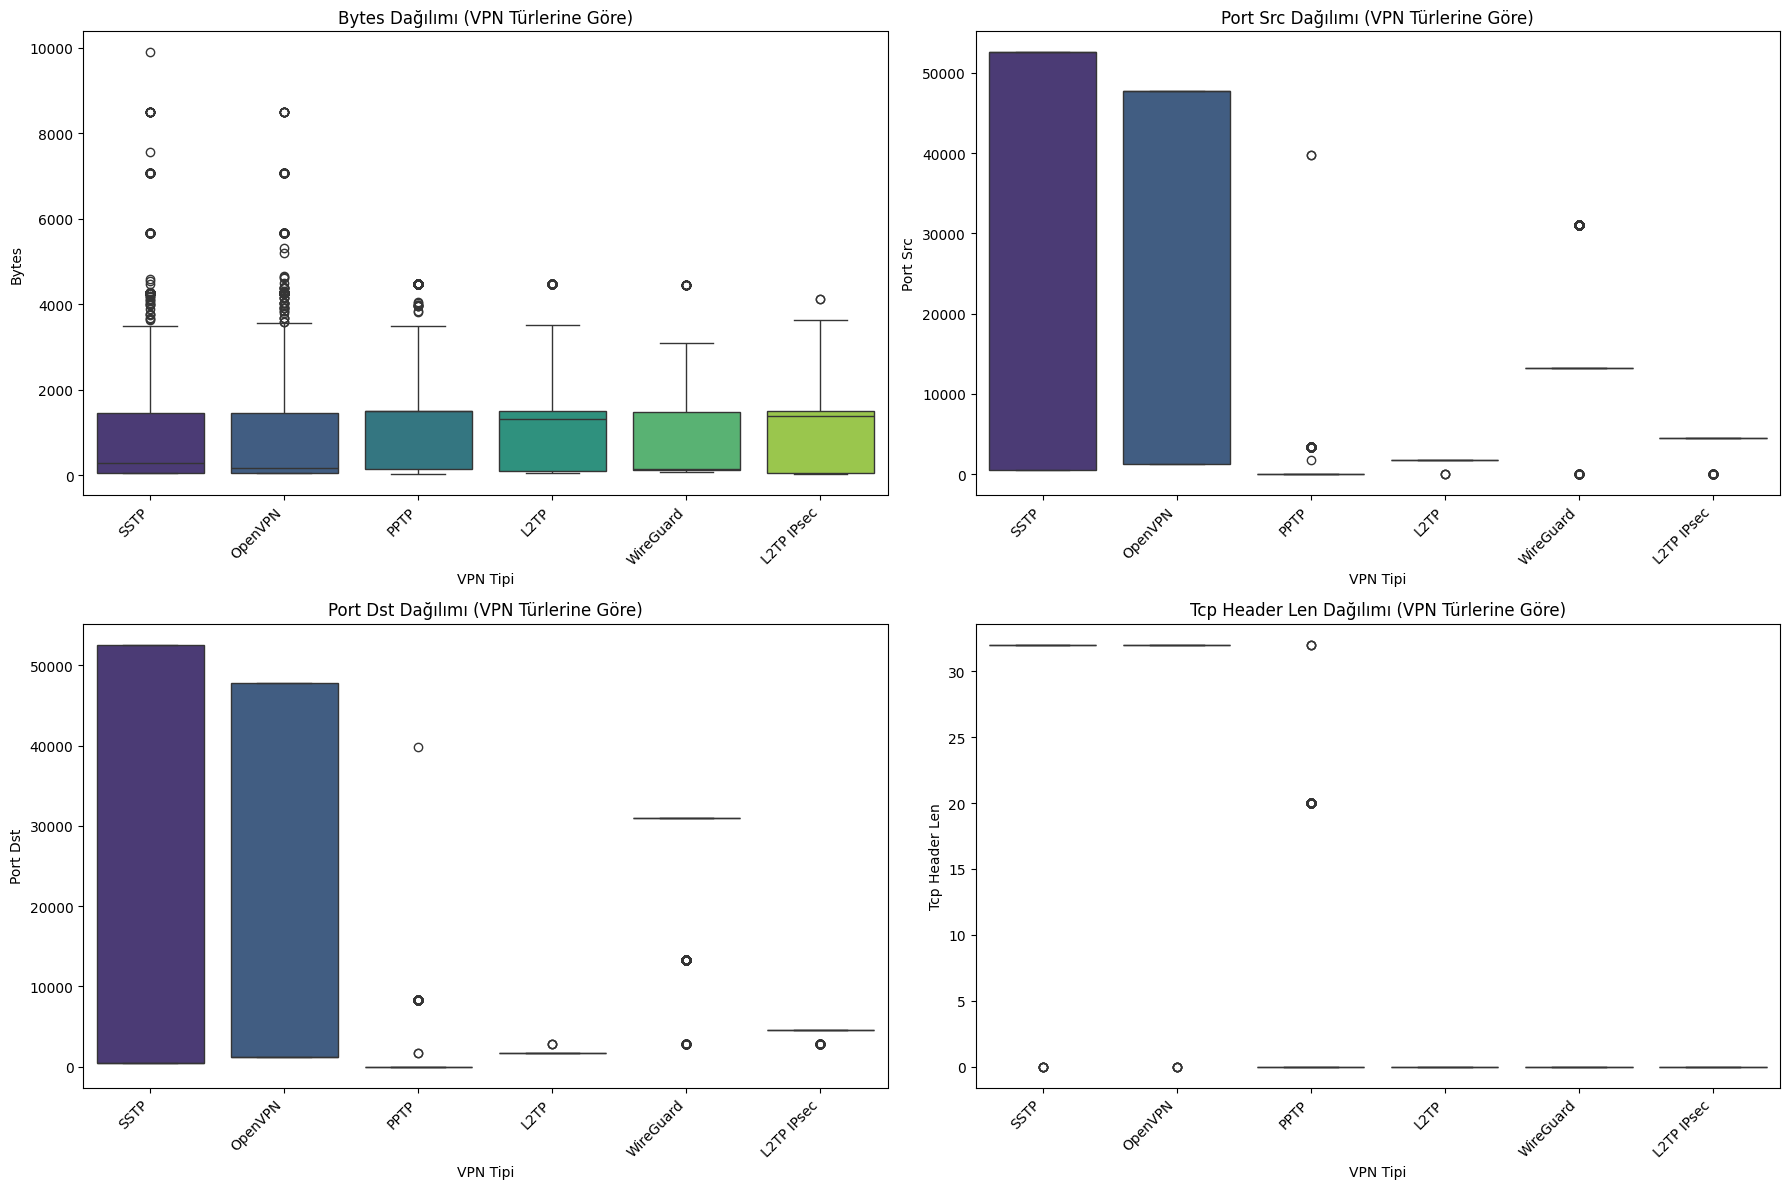

In [ ]:
plt.figure(figsize=(18, 12)) # Büyük bir figür boyutu, daha net görünüm için

features_to_plot = ['bytes', 'port_src', 'port_dst', 'tcp_header_len'] # ip_proto ve tcp_flags kategorik gibi davrandığı için hariç tutuldu

for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 2, i + 1) # 2 satır, 2 sütun düzeni
    sns.boxplot(data=df, x='vpn_type', y=feature, palette='viridis')
    plt.title(f'{feature.replace("_", " ").title()} Dağılımı (VPN Türlerine Göre)')
    plt.xlabel('VPN Tipi')
    plt.ylabel(feature.replace("_", " ").title())
    plt.xticks(rotation=45, ha='right') # Etiketleri döndürerek çakışmayı önle
plt.tight_layout()
plt.show()

<ipython-input-23-b4bc60f17948>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='vpn_type', palette='viridis', order=df['vpn_type'].value_counts().index)


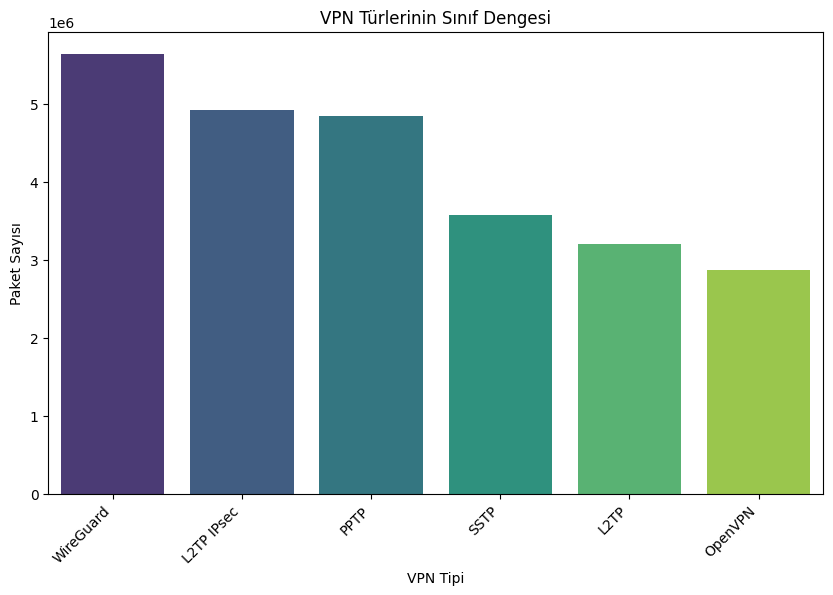

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='vpn_type', palette='viridis', order=df['vpn_type'].value_counts().index)
plt.title('VPN Türlerinin Sınıf Dengesi')
plt.xlabel('VPN Tipi')
plt.ylabel('Paket Sayısı')
plt.xticks(rotation=45, ha='right') # Etiketleri döndür
plt.show()

In [ ]:
# 'bytes' gibi büyük aralıklı özellikler için log dönüşümü
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['bytes']), kde=True, color='skyblue') # log1p: log(1+x), 0 değerlerini de yönetir
plt.title('Logaritmik Dönüştürülmüş Byte Boyutu Dağılımı')
plt.xlabel('Log(1 + Bytes)')
plt.ylabel('Frekans')
plt.show()



NameError: name 'plt' is not defined

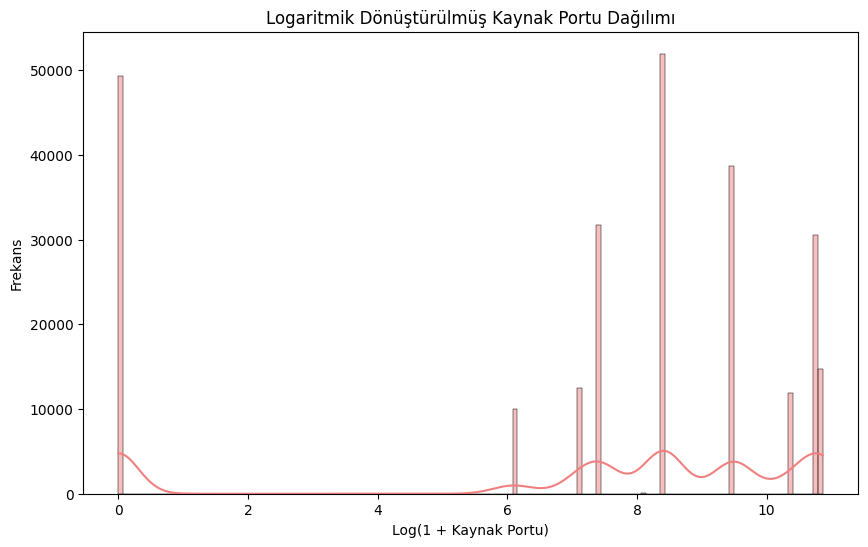

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['port_src']), kde=True, color='lightcoral')
plt.title('Logaritmik Dönüştürülmüş Kaynak Portu Dağılımı')
plt.xlabel('Log(1 + Kaynak Portu)')
plt.ylabel('Frekans')
plt.show()

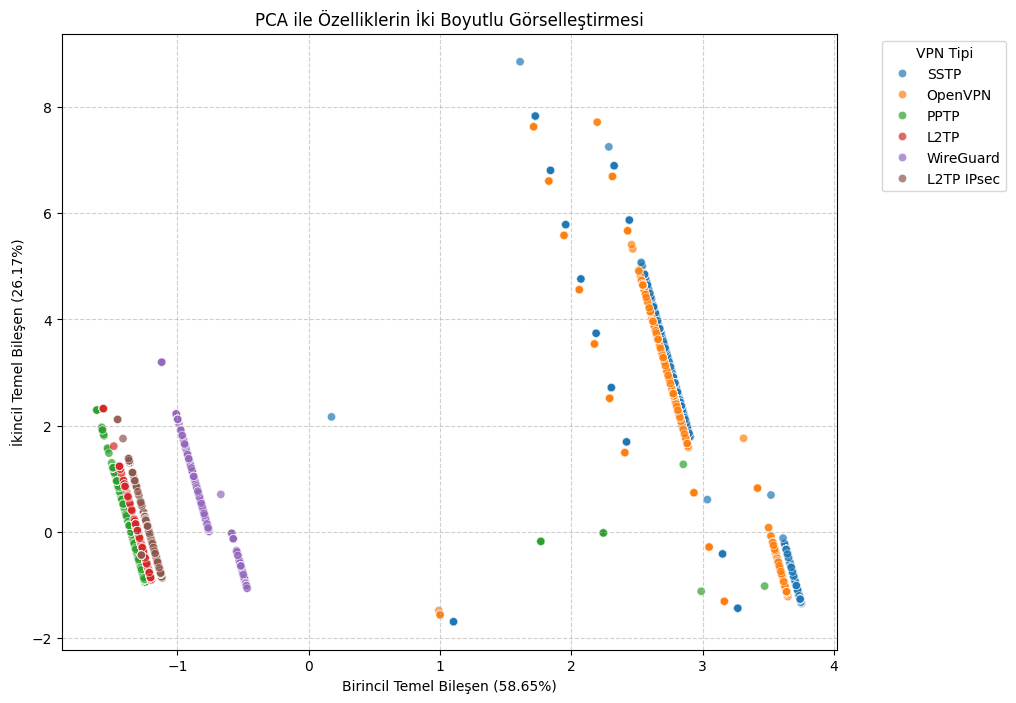

In [ ]:
from sklearn.decomposition import PCA

# X_scaled zaten mevcut olmalı
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled) # X_scaled'i kullanın

plt.figure(figsize=(10, 8))
# Her bir VPN türü için farklı renkte noktalar çiz
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['vpn_type'], palette='tab10', alpha=0.7)
plt.title('PCA ile Özelliklerin İki Boyutlu Görselleştirmesi')
plt.xlabel(f'Birincil Temel Bileşen ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'İkincil Temel Bileşen ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.legend(title='VPN Tipi', bbox_to_anchor=(1.05, 1), loc='upper left') # Legend'ı dışarı al
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

<Figure size 1500x800 with 0 Axes>

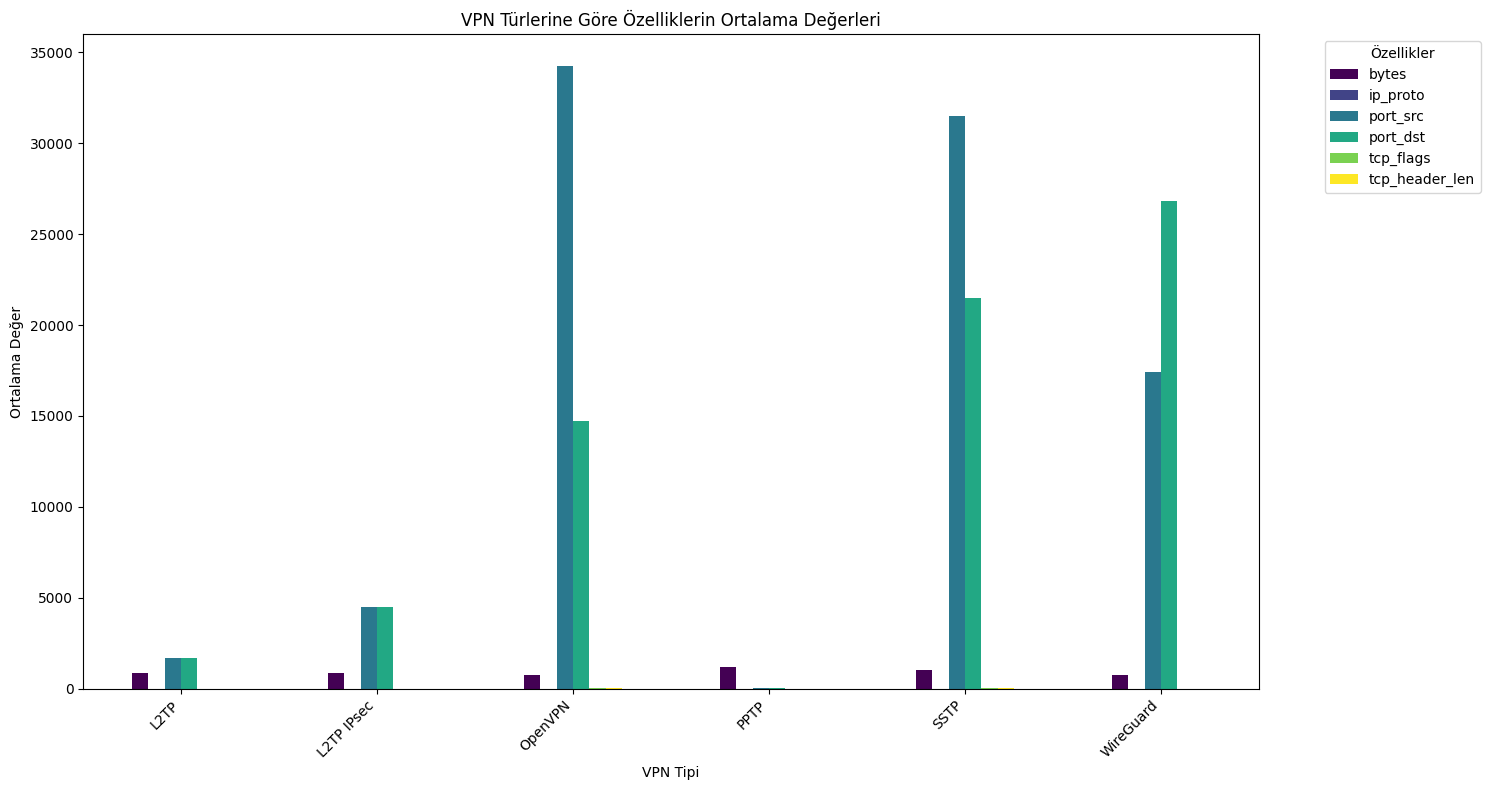

In [ ]:
plt.figure(figsize=(15, 8))
# Sayısal özelliklerin ortalamalarını vpn_type'a göre grupla
avg_features_by_vpn = df.groupby('vpn_type')[features].mean() # features listesi yukarıda tanımlı
avg_features_by_vpn.plot(kind='bar', figsize=(15, 8), colormap='viridis')
plt.title('VPN Türlerine Göre Özelliklerin Ortalama Değerleri')
plt.xlabel('VPN Tipi')
plt.ylabel('Ortalama Değer')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Özellikler', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-18-e5ed3aa19067>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='vpn_type', y='port_src', data=df, palette='viridis', inner='quartile')


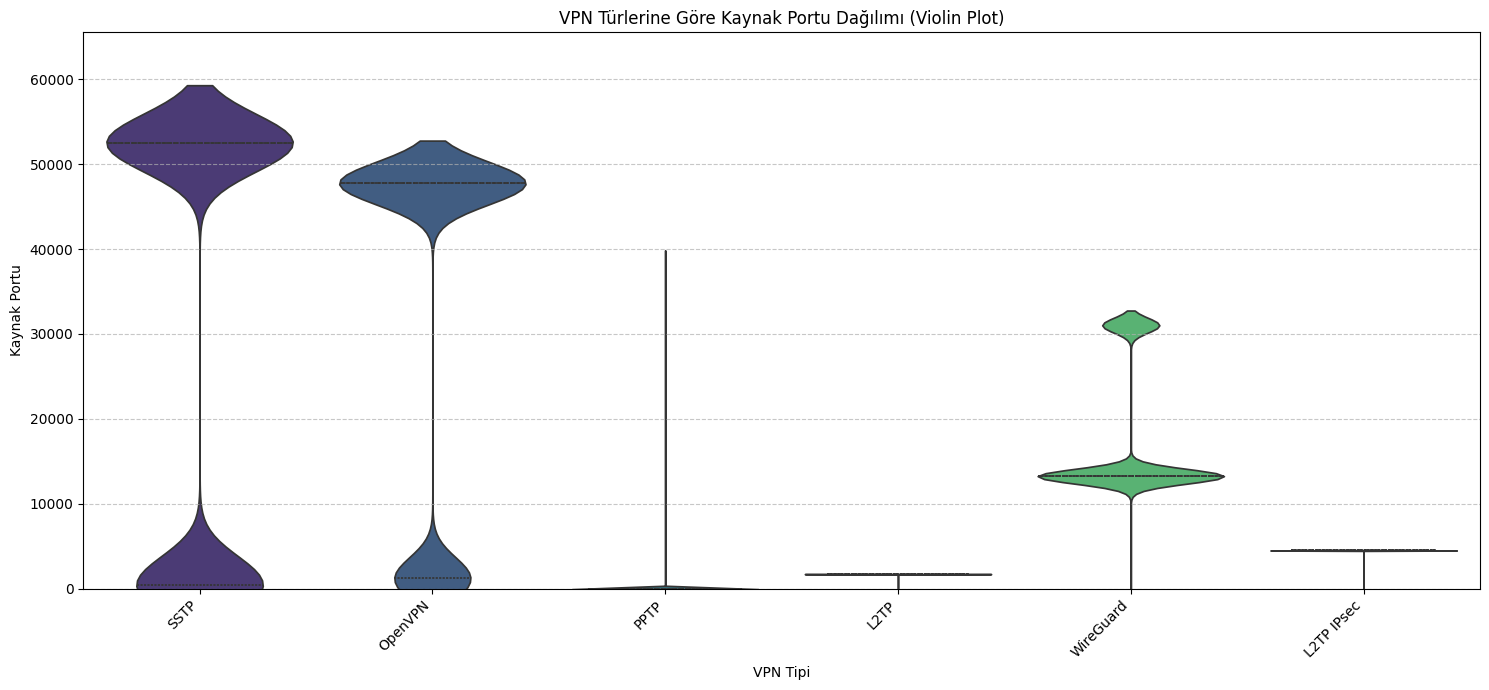

<ipython-input-18-e5ed3aa19067>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='vpn_type', y='port_dst', data=df, palette='magma', inner='quartile')


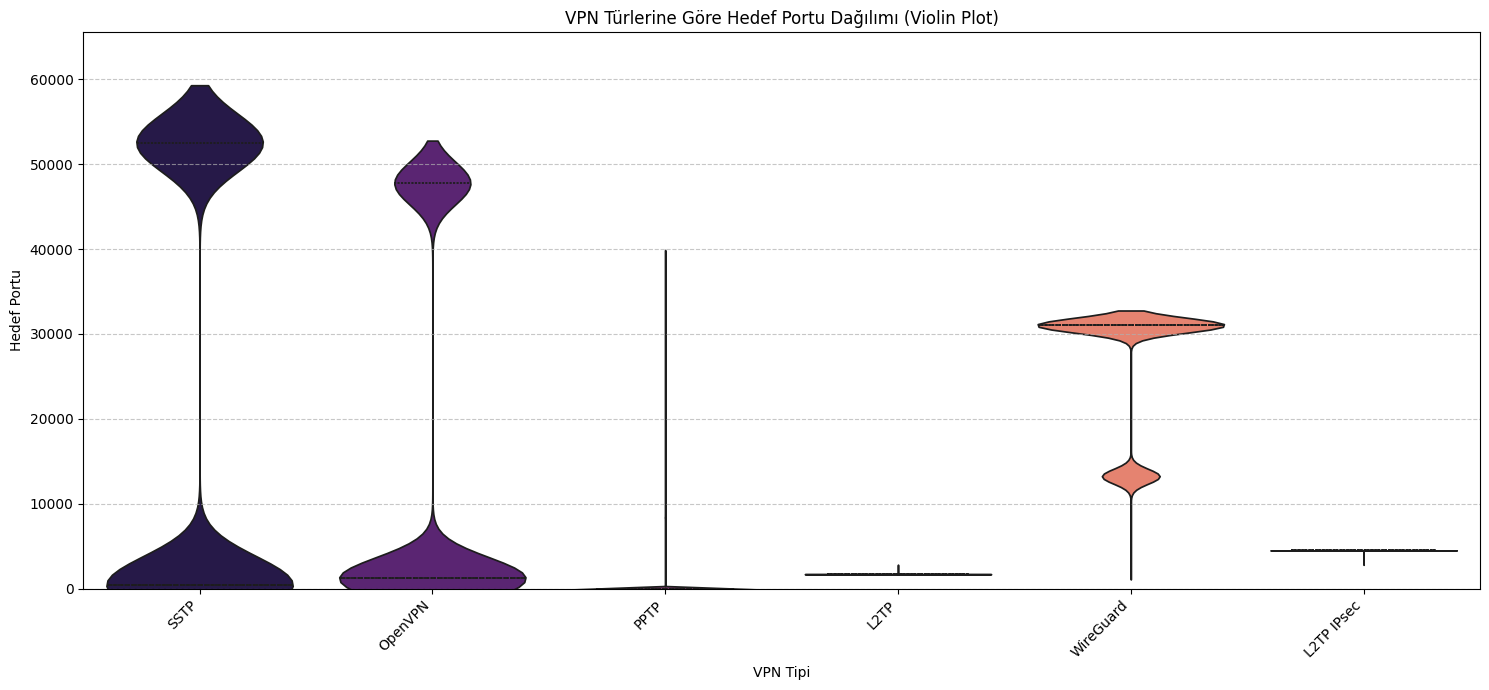

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 'df' DataFrame'i ve 'vpn_type' sütunu mevcut varsayılır.

# Kaynak Port (port_src) dağılımı
plt.figure(figsize=(15, 7))
sns.violinplot(x='vpn_type', y='port_src', data=df, palette='viridis', inner='quartile')
plt.title('VPN Türlerine Göre Kaynak Portu Dağılımı (Violin Plot)')
plt.xlabel('VPN Tipi')
plt.ylabel('Kaynak Portu')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 65535) # Port aralığı (0-65535)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Hedef Port (port_dst) dağılımı
plt.figure(figsize=(15, 7))
sns.violinplot(x='vpn_type', y='port_dst', data=df, palette='magma', inner='quartile')
plt.title('VPN Türlerine Göre Hedef Portu Dağılımı (Violin Plot)')
plt.xlabel('VPN Tipi')
plt.ylabel('Hedef Portu')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 65535) # Port aralığı (0-65535)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

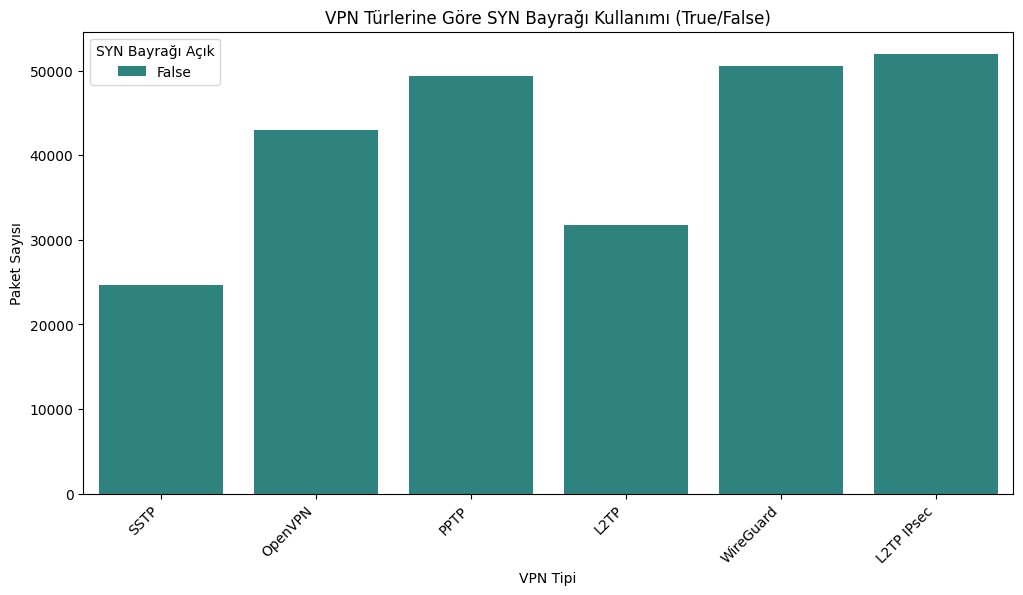

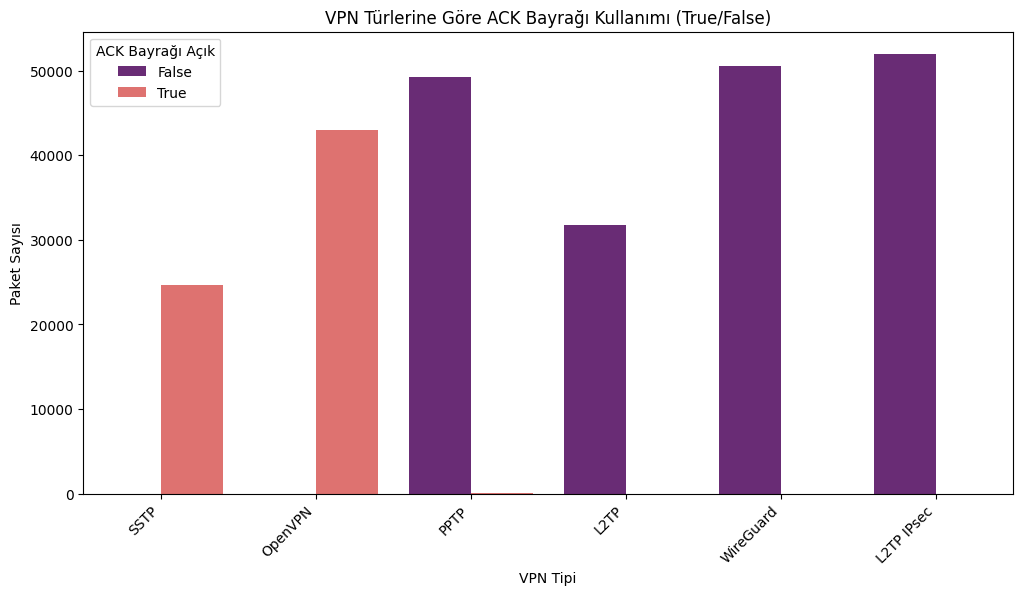

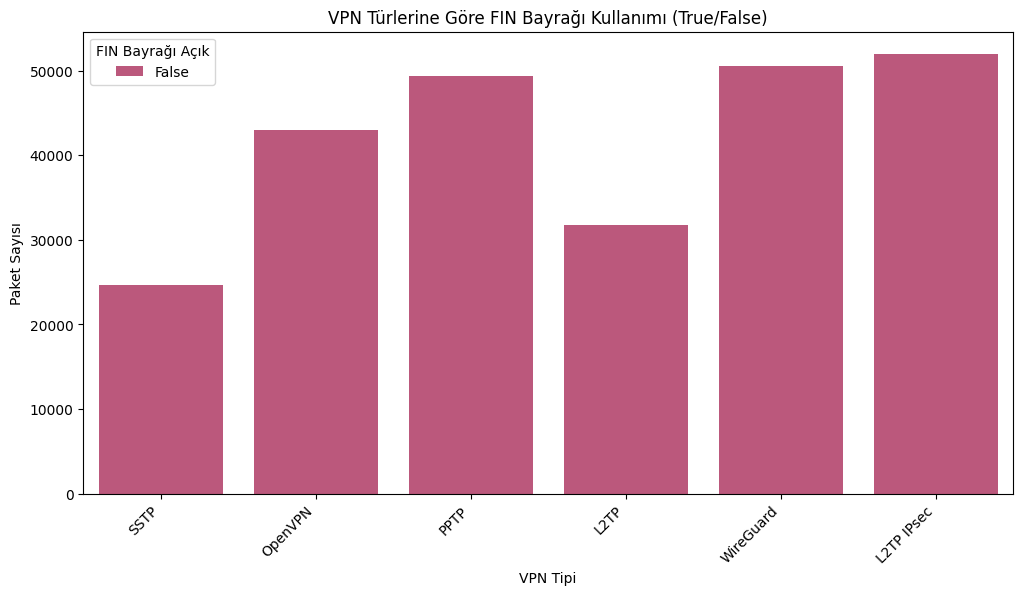

In [ ]:
# 'df' DataFrame'i mevcut varsayılır.

# TCP Flag değerlerini ikili (binary) formata çevirerek okunur hale getirme fonksiyonu (isteğe bağlı ama faydalı)
# SYN (2), ACK (16), FIN (1), RST (4), PSH (8), URG (32)
# Örneğin, SYN = 0x02 = 2
# ACK = 0x10 = 16
# FIN = 0x01 = 1
# RST = 0x04 = 4
# PSH = 0x08 = 8
# URG = 0x20 = 32

def check_tcp_flag(flags_value, flag_mask):
    """Verilen tcp_flags değerinde belirli bir bayrağın açık olup olmadığını kontrol eder."""
    return (flags_value & flag_mask) > 0

# Her bir VPN türü için TCP Flag dağılımını gösteren çubuk grafikler
# Örnek: SYN bayrağının dağılımı
df['has_syn'] = df['tcp_flags'].apply(lambda x: check_tcp_flag(x, 2)) # SYN bayrağı maskesi 2

plt.figure(figsize=(12, 6))
sns.countplot(x='vpn_type', hue='has_syn', data=df, palette='viridis')
plt.title('VPN Türlerine Göre SYN Bayrağı Kullanımı (True/False)')
plt.xlabel('VPN Tipi')
plt.ylabel('Paket Sayısı')
plt.xticks(rotation=45, ha='right')
plt.legend(title='SYN Bayrağı Açık')
plt.show()

# Örnek: ACK bayrağının dağılımı
df['has_ack'] = df['tcp_flags'].apply(lambda x: check_tcp_flag(x, 16)) # ACK bayrağı maskesi 16

plt.figure(figsize=(12, 6))
sns.countplot(x='vpn_type', hue='has_ack', data=df, palette='magma')
plt.title('VPN Türlerine Göre ACK Bayrağı Kullanımı (True/False)')
plt.xlabel('VPN Tipi')
plt.ylabel('Paket Sayısı')
plt.xticks(rotation=45, ha='right')
plt.legend(title='ACK Bayrağı Açık')
plt.show()

# Örnek: FIN bayrağının dağılımı
df['has_fin'] = df['tcp_flags'].apply(lambda x: check_tcp_flag(x, 1)) # FIN bayrağı maskesi 1

plt.figure(figsize=(12, 6))
sns.countplot(x='vpn_type', hue='has_fin', data=df, palette='plasma')
plt.title('VPN Türlerine Göre FIN Bayrağı Kullanımı (True/False)')
plt.xlabel('VPN Tipi')
plt.ylabel('Paket Sayısı')
plt.xticks(rotation=45, ha='right')
plt.legend(title='FIN Bayrağı Açık')
plt.show()

# Bu temporary sütunları silebiliriz:
df = df.drop(columns=['has_syn', 'has_ack', 'has_fin'])

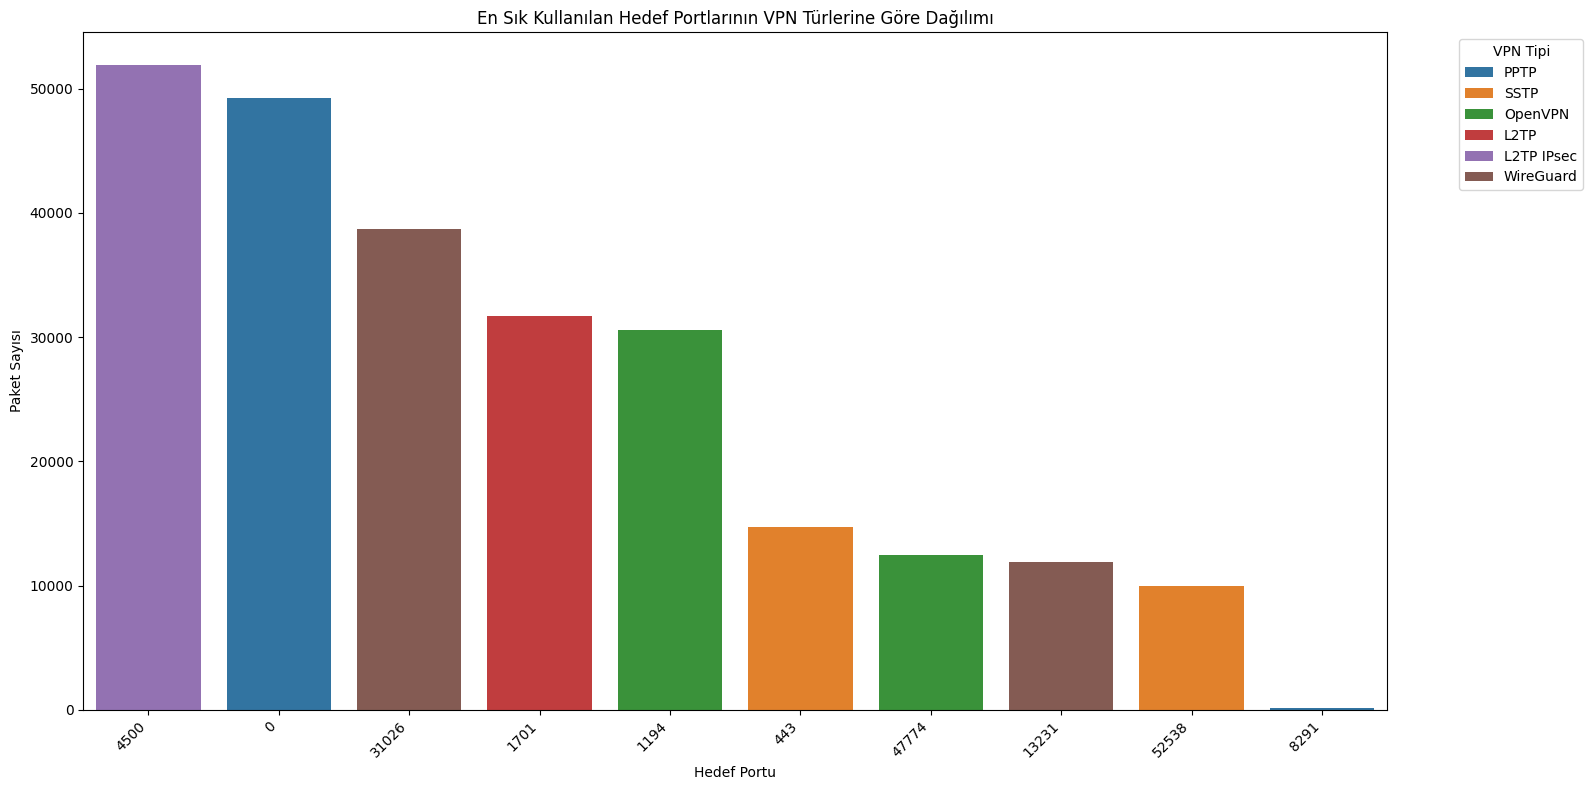

In [ ]:
# 'df' DataFrame'i mevcut varsayılır.

# En sık kullanılan ilk 10 hedef portunu bulalım
top_n_ports = df['port_dst'].value_counts().nlargest(10).index.tolist()

# Sadece bu top N portlara sahip verileri filtrele
df_filtered_ports = df[df['port_dst'].isin(top_n_ports)]

plt.figure(figsize=(16, 8))
sns.countplot(data=df_filtered_ports, x='port_dst', hue='vpn_type', palette='tab10',
              order=top_n_ports) # Portları en çoktan aza sırala
plt.title('En Sık Kullanılan Hedef Portlarının VPN Türlerine Göre Dağılımı')
plt.xlabel('Hedef Portu')
plt.ylabel('Paket Sayısı')
plt.xticks(rotation=45, ha='right')
plt.legend(title='VPN Tipi', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

AŞAĞIDA UYGULAMA EĞİTİMİ VAR

In [ ]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import gc
from google.colab import drive

drive.mount('/content/drive')

base_dataset_path = '/content/drive/MyDrive/Classroom/BigDataDersi/my_dataset'
vpn_folders = ['SSTP', 'OpenVPN', 'PPTP', 'L2TP', 'WireGuard', 'L2TP IPsec']
target_file_names = ['meet.json', 'mail.json', 'ssh.json', 'streaming.json']

data = []

for folder in vpn_folders:
    vpn_path = os.path.join(base_dataset_path, 'VPN', folder)
    for file_name in target_file_names:
        path = os.path.join(vpn_path, file_name)
        if not os.path.isfile(path):
            print(f"Uyarı: Dosya bulunamadı: {path}")
            continue

        with open(path) as f:
            try:
                sessions = json.load(f)
                app_type = file_name.replace('.json', '')
                print(f"VPN '{folder}/{file_name}' dosyasından {len(sessions)} oturum yüklendi. Uygulama Tipi: {app_type}")
                sessions_to_process = sessions

                for session in sessions_to_process:
                    proto = session.get("ip_proto", "").lower()
                    for packet in session.get("x_packets", []):
                        try:
                            data.append({
                                "bytes": int(packet.get("bytes", 0)),
                                "ip_proto": 1 if proto == "tcp" else 0,
                                "port_src": session.get("port_src", -1),
                                "port_dst": session.get("port_dst", -1),
                                "tcp_flags": int(packet.get("tcp_flags", "000000"), 2) if proto == "tcp" else 0,
                                "tcp_header_len": int(packet.get("tcp_header_len", 0)) if proto == "tcp" else 0,
                                "application_type": app_type
                            })
                        except ValueError:
                            continue
            except json.JSONDecodeError:
                print(f"Uyarı: JSON okuma hatası: {path}")
                continue
            except Exception as e:
                print(f"Beklenmeyen hata: {e} - Dosya: {path}")
                continue

non_vpn_path = os.path.join(base_dataset_path, 'Non VPN')
for file_name in target_file_names:
    path = os.path.join(non_vpn_path, file_name)
    if not os.path.isfile(path):
        print(f"Uyarı: Dosya bulunamadı: {path}")
        continue

    with open(path) as f:
        try:
            sessions = json.load(f)
            app_type = file_name.replace('.json', '')
            print(f"Non-VPN '{file_name}' dosyasından {len(sessions)} oturum yüklendi. Uygulama Tipi: {app_type}")
            sessions_to_process = sessions

            for session in sessions_to_process:
                proto = session.get("ip_proto", "").lower()
                for packet in session.get("x_packets", []):
                    try:
                        data.append({
                            "bytes": int(packet.get("bytes", 0)),
                            "ip_proto": 1 if proto == "tcp" else 0,
                            "port_src": session.get("port_src", -1),
                            "port_dst": session.get("port_dst", -1),
                            "tcp_flags": int(packet.get("tcp_flags", "000000"), 2) if proto == "tcp" else 0,
                            "tcp_header_len": int(packet.get("tcp_header_len", 0)) if proto == "tcp" else 0,
                            "application_type": app_type
                        })
                    except ValueError:
                        continue
        except json.JSONDecodeError:
            print(f"Uyarı: JSON okuma hatası: {path}")
            continue
        except Exception as e:
            print(f"Beklenmeyen hata: {e} - Dosya: {path}")
            continue

df = pd.DataFrame(data)
df = df[df['bytes'] >= 0]
print(f"Toplam {len(df)} adet paket verisi yüklendi.")

del data
gc.collect()

print("Bellek kullanımı (önce):", df.memory_usage(deep=True).sum() / (1024**2), "MB")
df['bytes'] = df['bytes'].astype(np.int32)
df['ip_proto'] = df['ip_proto'].astype(np.uint8)
df['port_src'] = df['port_src'].astype(np.int32)
df['port_dst'] = df['port_dst'].astype(np.int32)
df['tcp_flags'] = df['tcp_flags'].astype(np.uint16)
df['tcp_header_len'] = df['tcp_header_len'].astype(np.uint8)
print("Bellek kullanımı (sonra):", df.memory_usage(deep=True).sum() / (1024**2), "MB")

le = LabelEncoder()
df['application_type_encoded'] = le.fit_transform(df['application_type'])

X = df[['bytes', 'ip_proto', 'port_src', 'port_dst', 'tcp_flags', 'tcp_header_len']]
y = df['application_type_encoded']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("\nRandom Forest Modeli Eğitiliyor...")
model.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

print("\nModelle test setinde tahminler yapılıyor...")
y_pred = model.predict(X_test)

print("\n--- Model Değerlendirme Raporu ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("\nModel, Scaler ve LabelEncoder kaydediliyor...")
joblib.dump(model, '/content/drive/MyDrive/Classroom/BigDataDersi/application_type_classifier_model.pkl')
joblib.dump(le, '/content/drive/MyDrive/Classroom/BigDataDersi/application_type_label_encoder.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/Classroom/BigDataDersi/application_type_scaler.pkl')
print("Kaydetme işlemi tamamlandı.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
VPN 'SSTP/meet.json' dosyasından 2 oturum yüklendi. Uygulama Tipi: meet
VPN 'SSTP/mail.json' dosyasından 5 oturum yüklendi. Uygulama Tipi: mail
VPN 'SSTP/ssh.json' dosyasından 5 oturum yüklendi. Uygulama Tipi: ssh
VPN 'SSTP/streaming.json' dosyasından 97 oturum yüklendi. Uygulama Tipi: streaming
VPN 'OpenVPN/meet.json' dosyasından 2 oturum yüklendi. Uygulama Tipi: meet
VPN 'OpenVPN/mail.json' dosyasından 5 oturum yüklendi. Uygulama Tipi: mail
VPN 'OpenVPN/ssh.json' dosyasından 5 oturum yüklendi. Uygulama Tipi: ssh
VPN 'OpenVPN/streaming.json' dosyasından 98 oturum yüklendi. Uygulama Tipi: streaming
VPN 'PPTP/meet.json' dosyasından 2 oturum yüklendi. Uygulama Tipi: meet
VPN 'PPTP/mail.json' dosyasından 8 oturum yüklendi. Uygulama Tipi: mail
VPN 'PPTP/ssh.json' dosyasından 5 oturum yüklendi. Uygulama Tipi: ssh
VPN 'PPTP/streaming.json' dosyasından 145 oturum yü

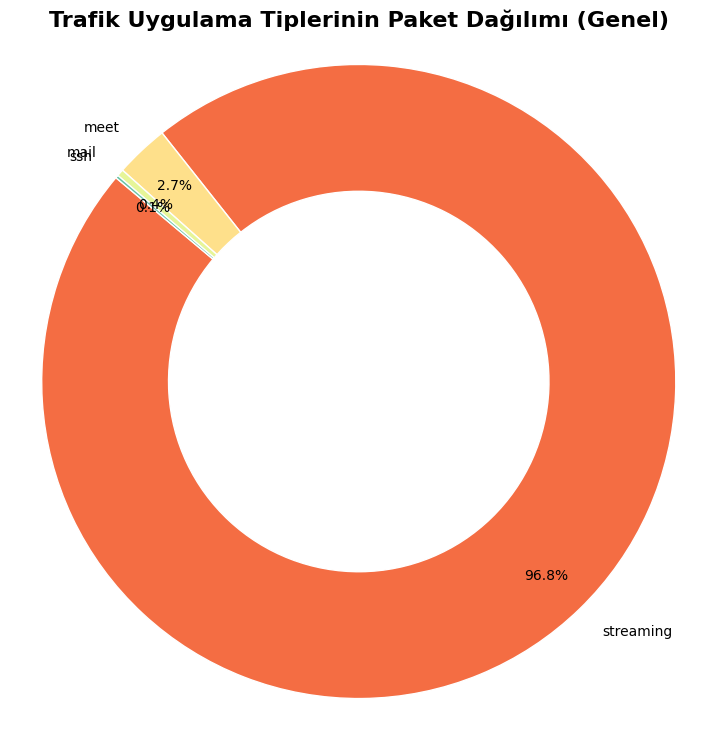

In [ ]:
plt.figure(figsize=(9, 9))
app_type_counts = df['application_type'].value_counts()
labels = app_type_counts.index
sizes = app_type_counts.values
colors = sns.color_palette("Spectral", len(labels)) # Canlı ve çeşitli renkler

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
plt.title('Trafik Uygulama Tiplerinin Paket Dağılımı (Genel)', fontsize=16, fontweight='bold')
plt.axis('equal') # Eşit oranlı daire için
plt.show()

<ipython-input-23-bd9451432234>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='application_type', y=feature, data=df, palette='viridis', inner='quartile', linewidth=1.5)
<ipython-input-23-bd9451432234>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='application_type', y=feature, data=df, palette='viridis', inner='quartile', linewidth=1.5)
<ipython-input-23-bd9451432234>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='application_type', y=feature, data=df, palette='viridis', inner='quartile', linewidth=1.5)
<ipython-inpu

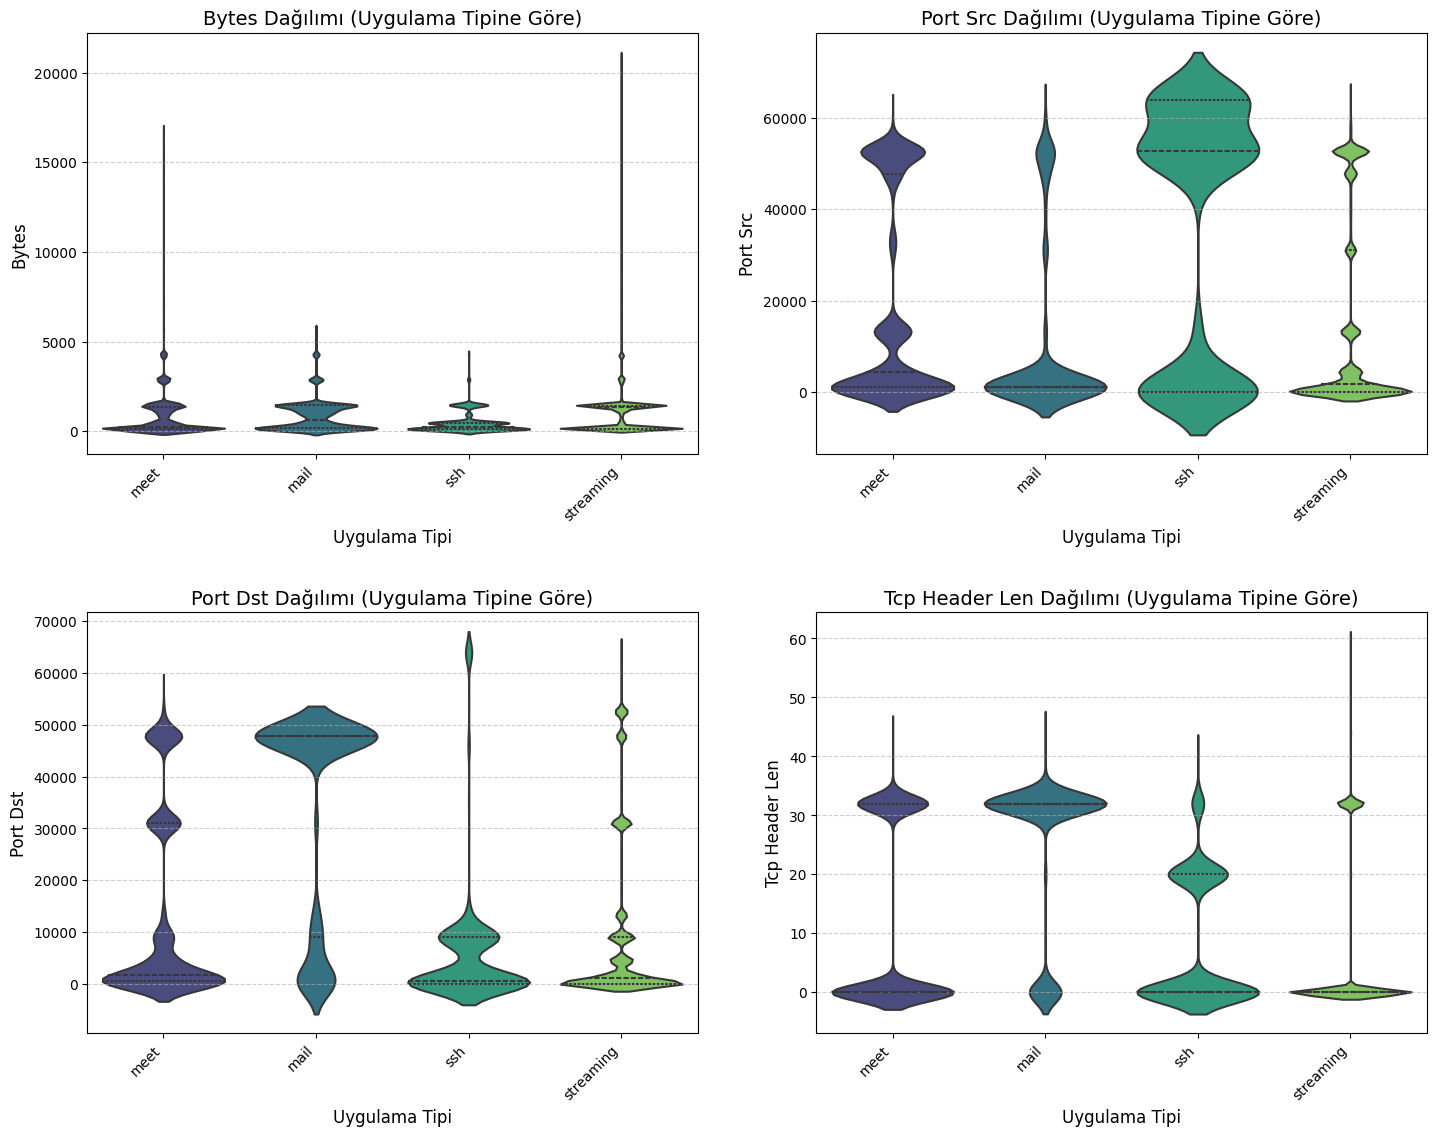

In [ ]:
features_to_plot = ['bytes', 'port_src', 'port_dst', 'tcp_header_len']
n_cols = 2
n_rows = (len(features_to_plot) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 6 * n_rows))

for i, feature in enumerate(features_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.violinplot(x='application_type', y=feature, data=df, palette='viridis', inner='quartile', linewidth=1.5)
    plt.title(f'{feature.replace("_", " ").title()} Dağılımı (Uygulama Tipine Göre)', fontsize=14)
    plt.xlabel('Uygulama Tipi', fontsize=12)
    plt.ylabel(feature.replace("_", " ").title(), fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout(pad=3.0)
plt.show()

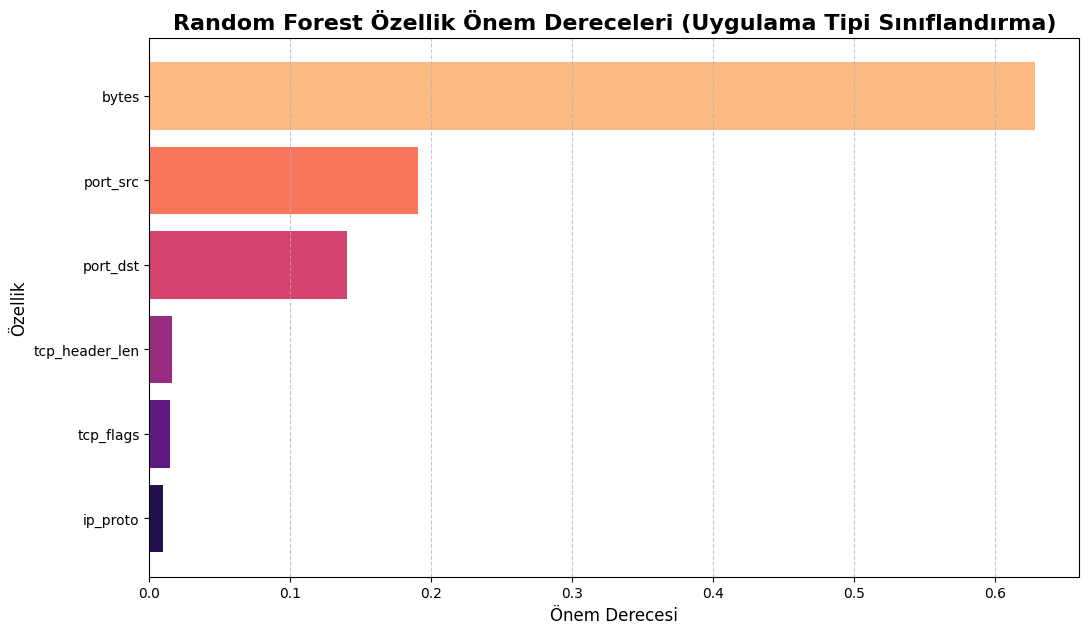

In [ ]:
plt.figure(figsize=(12, 7))
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
# Daha görsel ve renkli bir sıralama
feature_importances = feature_importances.sort_values(ascending=True)
colors = sns.color_palette("magma", len(feature_importances))

plt.barh(feature_importances.index, feature_importances.values, color=colors)
plt.title('Random Forest Özellik Önem Dereceleri (Uygulama Tipi Sınıflandırma)', fontsize=16, fontweight='bold')
plt.xlabel('Önem Derecesi', fontsize=12)
plt.ylabel('Özellik', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

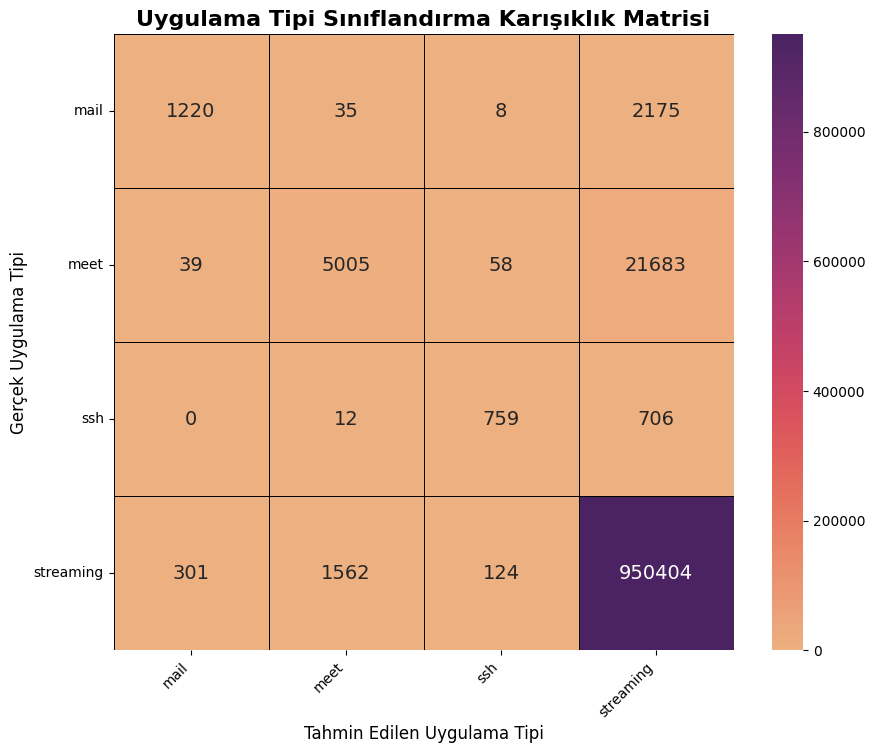

In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='flare', linewidths=.5, linecolor='black',
            xticklabels=le.classes_, yticklabels=le.classes_, annot_kws={"size": 14})
plt.title('Uygulama Tipi Sınıflandırma Karışıklık Matrisi', fontsize=16, fontweight='bold')
plt.xlabel('Tahmin Edilen Uygulama Tipi', fontsize=12)
plt.ylabel('Gerçek Uygulama Tipi', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

<ipython-input-26-13384705aa93>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='application_type', palette='crest', order=df['application_type'].value_counts().index)


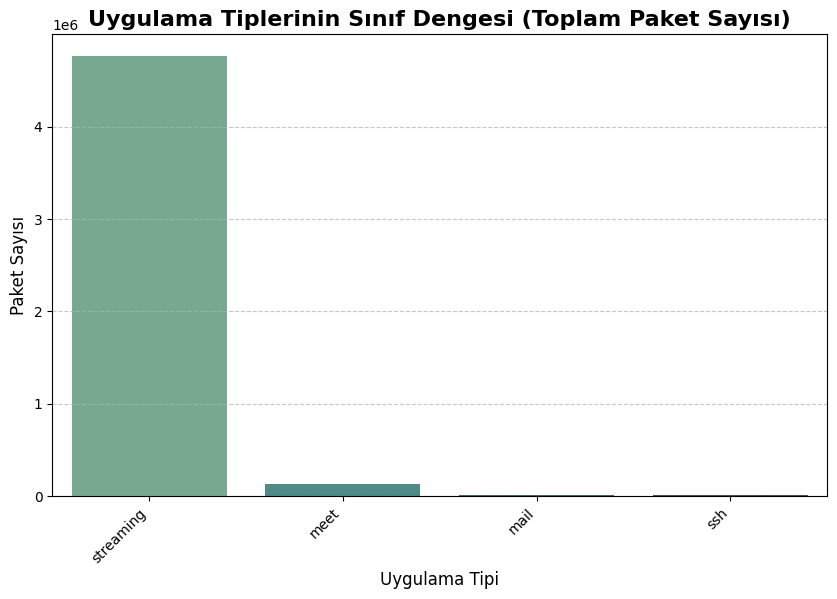

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='application_type', palette='crest', order=df['application_type'].value_counts().index)
plt.title('Uygulama Tiplerinin Sınıf Dengesi (Toplam Paket Sayısı)', fontsize=16, fontweight='bold')
plt.xlabel('Uygulama Tipi', fontsize=12)
plt.ylabel('Paket Sayısı', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

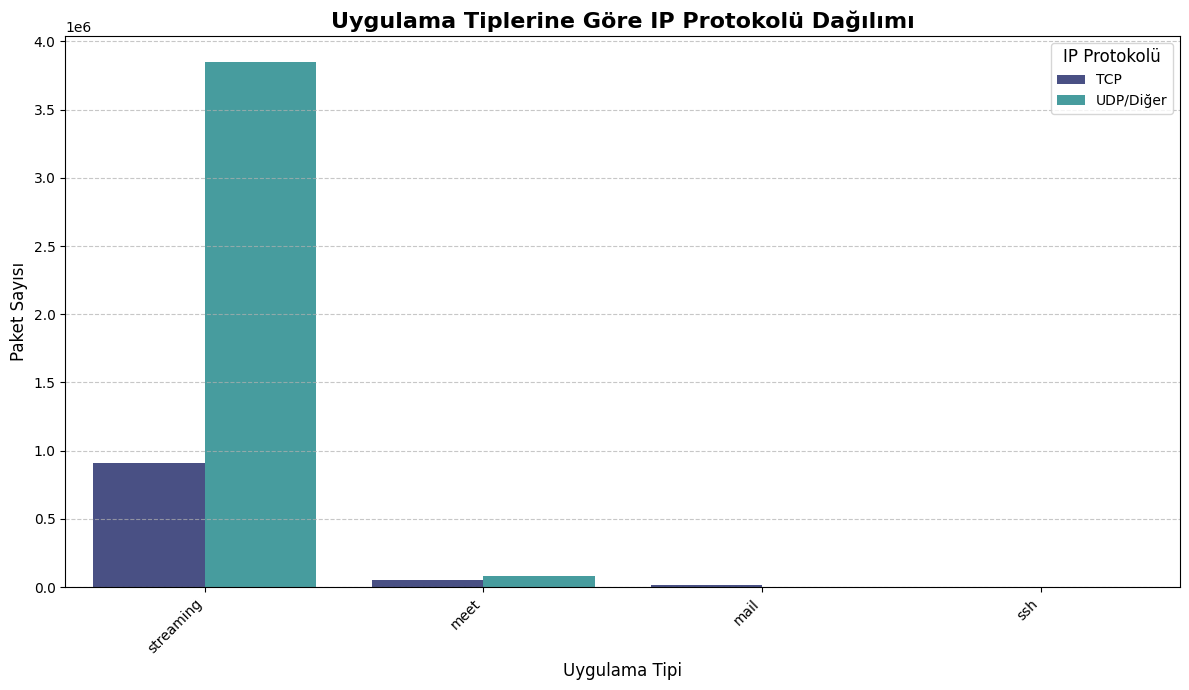

In [ ]:
plt.figure(figsize=(12, 7))
# ip_proto sütununu okunabilir hale getirelim (0: UDP/Diğer, 1: TCP)
df_plot = df.copy()
df_plot['ip_proto_label'] = df_plot['ip_proto'].map({1: 'TCP', 0: 'UDP/Diğer'})

sns.countplot(data=df_plot, x='application_type', hue='ip_proto_label', palette='mako',
              order=df_plot['application_type'].value_counts().index) # En çoktan aza sırala
plt.title('Uygulama Tiplerine Göre IP Protokolü Dağılımı', fontsize=16, fontweight='bold')
plt.xlabel('Uygulama Tipi', fontsize=12)
plt.ylabel('Paket Sayısı', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='IP Protokolü', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
!pip install gradio



AŞAĞIDA VPN - NON ONA BAKIYOR

In [2]:
import gradio as gr
import joblib
import numpy as np

# 🔄 Model ve scaler'ı yükle
model = joblib.load('/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_detection_rf_model.pkl')
scaler = joblib.load('/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_detection_scaler.pkl')

# 🧠 Tahmin fonksiyonu
def predict_vpn(bytes, ip_proto, port_src, port_dst, tcp_flags, tcp_header_len):
    input_data = np.array([[bytes, ip_proto, port_src, port_dst, tcp_flags, tcp_header_len]])
    input_scaled = scaler.transform(input_data)
    prediction = model.predict(input_scaled)[0]
    return "VPN Trafiği" if prediction == 1 else "Non-VPN Trafiği"

# 🎛️ Arayüz
iface = gr.Interface(
    fn=predict_vpn,
    inputs=[
        gr.Number(label="Bytes"),
        gr.Radio(choices=[0, 1], label="IP Proto (0: UDP, 1: TCP)"),
        gr.Number(label="Source Port"),
        gr.Number(label="Destination Port"),
        gr.Number(label="TCP Flags (int)"),
        gr.Number(label="TCP Header Length")
    ],
    outputs="text",
    title="VPN Trafik Tespit Aracı",
    description="Ağ trafiğinin VPN olup olmadığını tahmin eden RandomForest modeli"
)

iface.launch()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_detection_rf_model.pkl'

VPN ISE HANGI TUR

In [ ]:
import gradio as gr
import joblib
import numpy as np

# 🔄 Modelleri ve scaler/encoder'ları yükle
binary_model = joblib.load('/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_detection_rf_model.pkl')
binary_scaler = joblib.load('/content/drive/MyDrive/Classroom/BigDataDersi/full_vpn_detection_scaler.pkl')

vpn_type_model = joblib.load('/content/drive/MyDrive/Classroom/BigDataDersi/sample_vpn_type_classifier_model.pkl')
vpn_type_scaler = joblib.load('/content/drive/MyDrive/Classroom/BigDataDersi/sample_vpn_type_scaler.pkl')
label_encoder = joblib.load('/content/drive/MyDrive/Classroom/BigDataDersi/sample_vpn_type_label_encoder.pkl')

# 🧠 Tahmin fonksiyonu
def predict_all(bytes, ip_proto, port_src, port_dst, tcp_flags, tcp_header_len):
    input_data = np.array([[bytes, ip_proto, port_src, port_dst, tcp_flags, tcp_header_len]])

    # VPN mi değil mi?
    input_binary_scaled = binary_scaler.transform(input_data)
    binary_pred = binary_model.predict(input_binary_scaled)[0]

    if binary_pred == 0:
        return "Non-VPN Trafiği", "-"

    # VPN türünü tahmin et
    input_type_scaled = vpn_type_scaler.transform(input_data)
    vpn_type_pred = vpn_type_model.predict(input_type_scaled)[0]
    vpn_type_label = label_encoder.inverse_transform([vpn_type_pred])[0]

    return "VPN Trafiği", f"VPN Türü: {vpn_type_label}"

# 🎛️ Arayüz
iface = gr.Interface(
    fn=predict_all,
    inputs=[
        gr.Number(label="Bytes"),
        gr.Radio(choices=[0, 1], label="IP Proto (0: UDP, 1: TCP)"),
        gr.Number(label="Source Port"),
        gr.Number(label="Destination Port"),
        gr.Number(label="TCP Flags (int)"),
        gr.Number(label="TCP Header Length")
    ],
    outputs=["text", "text"],
    title="VPN Trafik ve Türü Tespit Aracı",
    description="Verilen trafik bilgilerinden önce VPN olup olmadığını, sonra varsa hangi tür VPN olduğunu tahmin eden makine öğrenmesi aracı"
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://53fb86a5620a0daa1d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


HANGI UYGULAMA

In [3]:
import gradio as gr
import joblib
import numpy as np

# 🔄 Modelleri ve scaler/encoder'ları yükle
binary_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/full_vpn_detection_rf_model.pkl')
binary_scaler = joblib.load('/content/drive/MyDrive/Colab Notebooks/full_vpn_detection_scaler.pkl')

vpn_type_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/full_vpn_type_model.pkl')
vpn_type_scaler = joblib.load('/content/drive/MyDrive/Colab Notebooks/full_vpn_type_scaler.pkl')
vpn_label_encoder = joblib.load('/content/drive/MyDrive/Colab Notebooks/full_vpn_type_label_encoder.pkl')

app_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/application_type_classifier_model_small.pkl')
app_scaler = joblib.load('/content/drive/MyDrive/Colab Notebooks/application_type_scaler_small.pkl')
app_label_encoder = joblib.load('/content/drive/MyDrive/Colab Notebooks/application_type_label_encoder_small.pkl')

# 🧠 Tahmin fonksiyonu
def predict_all(bytes, ip_proto, port_src, port_dst, tcp_flags, tcp_header_len):
    input_data = np.array([[bytes, ip_proto, port_src, port_dst, tcp_flags, tcp_header_len]])

    # 1️⃣ VPN mi değil mi?
    input_binary_scaled = binary_scaler.transform(input_data)
    binary_pred = binary_model.predict(input_binary_scaled)[0]

    if binary_pred == 0:
        return "🌐 Non-VPN Trafiği", "-", "-"

    # 2️⃣ VPN türü tahmini
    input_type_scaled = vpn_type_scaler.transform(input_data)
    vpn_type_pred = vpn_type_model.predict(input_type_scaled)[0]
    vpn_type_label = vpn_label_encoder.inverse_transform([vpn_type_pred])[0]

    # 3️⃣ Uygulama tipi tahmini (sadece VPN için)
    input_app_scaled = app_scaler.transform(input_data)
    app_pred = app_model.predict(input_app_scaled)[0]
    app_label = app_label_encoder.inverse_transform([app_pred])[0]

    return "🔐 VPN Trafiği", f"VPN Türü: {vpn_type_label}", f"📱 Uygulama Tipi: {app_label}"

# 🎛️ Arayüz
iface = gr.Interface(
    fn=predict_all,
    inputs=[
        gr.Number(label="Bytes"),
        gr.Radio(choices=[0, 1], label="IP Proto (0: UDP, 1: TCP)"),
        gr.Number(label="Source Port"),
        gr.Number(label="Destination Port"),
        gr.Number(label="TCP Flags (int)"),
        gr.Number(label="TCP Header Length")
    ],
    outputs=["text", "text", "text"],
    title="VPN Trafik Sınıflandırıcı (VPN + Tür + Uygulama Tipi)",
    description="Verilen trafik özelliklerine göre önce VPN olup olmadığını, ardından VPN türünü ve uygulama tipini tahmin eden sistem."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1d6254a322ff9219d8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import joblib
import numpy as np

# 🔄 Modelleri ve scaler/encoder'ları yükle
binary_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/full_vpn_detection_rf_model.pkl')
binary_scaler = joblib.load('/content/drive/MyDrive/Colab Notebooks/full_vpn_detection_scaler.pkl')

vpn_type_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/full_vpn_type_model.pkl')
vpn_type_scaler = joblib.load('/content/drive/MyDrive/Colab Notebooks/full_vpn_type_scaler.pkl')
vpn_label_encoder = joblib.load('/content/drive/MyDrive/Colab Notebooks/full_vpn_type_label_encoder.pkl')

app_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/application_type_classifier_model_small.pkl')
app_scaler = joblib.load('/content/drive/MyDrive/Colab Notebooks/application_type_scaler_small.pkl')
app_label_encoder = joblib.load('/content/drive/MyDrive/Colab Notebooks/application_type_label_encoder_small.pkl')

# 🧠 Tahmin fonksiyonu
def predict_all(bytes_val, ip_proto_val, port_src_val, port_dst_val, tcp_flags_val, tcp_header_len_val):
    input_data = np.array([[bytes_val, ip_proto_val, port_src_val, port_dst_val, tcp_flags_val, tcp_header_len_val]])

    # 1️⃣ VPN mi değil mi?
    input_binary_scaled = binary_scaler.transform(input_data)
    binary_pred = binary_model.predict(input_binary_scaled)[0]

    vpn_status_message = ""
    vpn_type_message = ""
    app_type_message = ""

    if binary_pred == 0:
        vpn_status_message = "🌐 Non-VPN Trafiği"
    else:
        vpn_status_message = "🔐 VPN Trafiği"

    # 2️⃣ VPN türü tahmini (her zaman çalışsın)
    input_type_scaled = vpn_type_scaler.transform(input_data)
    vpn_type_pred = vpn_type_model.predict(input_type_scaled)[0]
    vpn_type_label = vpn_label_encoder.inverse_transform([vpn_type_pred])[0]
    vpn_type_message = f"VPN Türü: {vpn_type_label}"

    # 3️⃣ Uygulama tipi tahmini (her zaman çalışsın)
    input_app_scaled = app_scaler.transform(input_data)
    app_pred = app_model.predict(input_app_scaled)[0]
    app_label = app_label_encoder.inverse_transform([app_pred])[0]
    app_type_message = f"📱 Uygulama Tipi: {app_label}"

    return vpn_status_message, vpn_type_message, app_type_message

# 🎛️ Arayüz
iface = gr.Interface(
    fn=predict_all,
    inputs=[
        gr.Number(label="Bytes"),
        gr.Radio(choices=[0, 1], label="IP Proto (0: UDP, 1: TCP)"),
        gr.Number(label="Source Port"),
        gr.Number(label="Destination Port"),
        gr.Number(label="TCP Flags (int)"),
        gr.Number(label="TCP Header Length")
    ],
    outputs=["text", "text", "text"],
    title="VPN Trafik Sınıflandırıcı (VPN + Tür + Uygulama Tipi)",
    description="Verilen trafik özelliklerine göre önce VPN olup olmadığını, ardından VPN türünü ve uygulama tipini tahmin eden sistem."
)

iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7c17238781e26e9955.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


SADECE HANGI UYGULAMA

In [4]:
import gradio as gr
import joblib
import numpy as np

# 🔄 Modelleri ve scaler/encoder'ları yükle
binary_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/full_vpn_detection_rf_model.pkl')
binary_scaler = joblib.load('/content/drive/MyDrive/Colab Notebooks/full_vpn_detection_scaler.pkl')

vpn_type_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/full_vpn_type_model.pkl')
vpn_type_scaler = joblib.load('/content/drive/MyDrive/Colab Notebooks/full_vpn_type_scaler.pkl')
vpn_label_encoder = joblib.load('/content/drive/MyDrive/Colab Notebooks/full_vpn_type_label_encoder.pkl')

app_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/application_type_classifier_model_small.pkl')
app_scaler = joblib.load('/content/drive/MyDrive/Colab Notebooks/application_type_scaler_small.pkl')
app_label_encoder = joblib.load('/content/drive/MyDrive/Colab Notebooks/application_type_label_encoder_small.pkl')

# 🧠 Tahmin fonksiyonu
def predict_all(bytes, ip_proto, port_src, port_dst, tcp_flags, tcp_header_len):
    input_data = np.array([[bytes, ip_proto, port_src, port_dst, tcp_flags, tcp_header_len]])

    # Tüm tahminler için scaler'ları hazırla
    input_binary_scaled = binary_scaler.transform(input_data)
    input_app_scaled = app_scaler.transform(input_data)

    # 1️⃣ VPN mi değil mi?
    binary_pred = binary_model.predict(input_binary_scaled)[0]

    # 3️⃣ Uygulama tipi tahmini (her zaman gösterilecek)
    app_pred = app_model.predict(input_app_scaled)[0]
    app_label = app_label_encoder.inverse_transform([app_pred])[0]
    app_type_message = f"📱 Uygulama Tipi: {app_label}"

    if binary_pred == 0:
        # Non-VPN ise VPN türünü gösterme
        return "🌐 Non-VPN Trafiği", "-", app_type_message
    else:
        # VPN ise VPN türünü de tahmin et
        input_type_scaled = vpn_type_scaler.transform(input_data)
        vpn_type_pred = vpn_type_model.predict(input_type_scaled)[0]
        vpn_type_label = vpn_label_encoder.inverse_transform([vpn_type_pred])[0]
        vpn_type_message = f"VPN Türü: {vpn_type_label}"

        return "🔐 VPN Trafiği", vpn_type_message, app_type_message

# 🎛️ Arayüz
iface = gr.Interface(
    fn=predict_all,
    inputs=[
        gr.Number(label="Bytes"),
        gr.Radio(choices=[0, 1], label="IP Proto (0: UDP, 1: TCP)"),
        gr.Number(label="Source Port"),
        gr.Number(label="Destination Port"),
        gr.Number(label="TCP Flags (int)"),
        gr.Number(label="TCP Header Length")
    ],
    outputs=["text", "text", "text"],
    title="VPN Trafik Sınıflandırıcı (VPN + Tür + Uygulama Tipi)",
    description="Verilen trafik özelliklerine göre önce VPN olup olmadığını, ardından (eğer VPN ise) VPN türünü ve uygulama tipini tahmin eden sistem."
)

iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cc3257aa8de25e33f4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
